In [1]:
from keras.optimizers import Adam



from keras.layers import Dense, Input, concatenate



from keras.models import Model



import matplotlib.pyplot as plt

from tensorflow.keras.regularizers import l1

from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import Dropout

In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
import random



import tensorflow as tf



import numpy as np







# Set global seeds



seed = 42



tf.random.set_seed(seed)



np.random.seed(seed)



random.seed(seed)

In [4]:
'''
Script: resnet_builder_keras.py
Dependency environment: tf_gpu

Script for building 3D Resnet models in pure Keras. 
Code adapted from https://github.com/JihongJu/keras-resnet3d updated for TF2.0
'''

from __future__ import (
    absolute_import,
    division,
    print_function,
    unicode_literals
)
import six
from math import ceil
import keras
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Add
)

from keras.layers import (
    Conv3D,
    AveragePooling3D,
    MaxPooling3D,
)

from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN (non-trainable) -> relu block."""
    norm = BatchNormalization(axis=CHANNEL_AXIS, trainable=False)(input)  # Set trainable to False
    return Activation("relu")(norm)


def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault(
        "kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer",
                                                l2(1e-4))

    def f(input):
        conv = Conv3D(filters=filters, kernel_size=kernel_size,
                      strides=strides, kernel_initializer=kernel_initializer,
                      padding=padding,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv3d(**conv_params):
    """Helper to build a  BN -> relu -> conv3d block."""
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer",
                                                "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer",
                                                l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(filters=filters, kernel_size=kernel_size,
                      strides=strides, kernel_initializer=kernel_initializer,
                      padding=padding,
                      kernel_regularizer=kernel_regularizer)(activation)
    return f


def _shortcut3d(input, residual):
    """3D shortcut to match input and residual and merges them with "sum"."""
    stride_dim1 = ceil(int(input.shape[DIM1_AXIS]) \
        / float(int(residual.shape[DIM1_AXIS])))
    stride_dim2 = ceil(int(input.shape[DIM2_AXIS]) \
        / float(int(residual.shape[DIM2_AXIS])))
    stride_dim3 = ceil(int(input.shape[DIM3_AXIS]) \
        / float(int(residual.shape[DIM3_AXIS])))
    equal_channels = residual.shape[CHANNEL_AXIS] \
        == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 \
            or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal", padding="valid",
            kernel_regularizer=l2(1e-4)
            )(input)
    return Add()([shortcut, residual])


def _residual_block3d(block_function, filters, kernel_regularizer, repetitions,
                      is_first_layer=False):
    def f(input):
        for i in range(repetitions):
            strides = (1, 1, 1)
            if i == 0 and not is_first_layer:
                strides = (2, 2, 2)
            input = block_function(filters=filters, strides=strides,
                                   kernel_regularizer=kernel_regularizer,
                                   is_first_block_of_first_layer=(
                                       is_first_layer and i == 0)
                                   )(input)
        return input

    return f


def basic_block(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
                is_first_block_of_first_layer=False):
    """Basic 3 X 3 X 3 convolution blocks. Extended from raghakot's 2D impl."""
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv3D(filters=filters, kernel_size=(3, 3, 3),
                           strides=strides, padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=kernel_regularizer
                           )(input)
        else:
            conv1 = _bn_relu_conv3d(filters=filters,
                                    kernel_size=(3, 3, 3),
                                    strides=strides,
                                    kernel_regularizer=kernel_regularizer
                                    )(input)

        residual = _bn_relu_conv3d(filters=filters, kernel_size=(3, 3, 3),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv1)
        return _shortcut3d(input, residual)

    return f


def bottleneck(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
               is_first_block_of_first_layer=False):
    """Basic 3 X 3 X 3 convolution blocks. Extended from raghakot's 2D impl."""
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv3D(filters=filters, kernel_size=(1, 1, 1),
                              strides=strides, padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=kernel_regularizer
                              )(input)
        else:
            conv_1_1 = _bn_relu_conv3d(filters=filters, kernel_size=(1, 1, 1),
                                       strides=strides,
                                       kernel_regularizer=kernel_regularizer
                                       )(input)

        conv_3_3 = _bn_relu_conv3d(filters=filters, kernel_size=(3, 3, 3),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv_1_1)
        residual = _bn_relu_conv3d(filters=filters * 4, kernel_size=(1, 1, 1),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv_3_3)

        return _shortcut3d(input, residual)

    return f


def _handle_data_format():
    global DIM1_AXIS
    global DIM2_AXIS
    global DIM3_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        DIM1_AXIS = 1
        DIM2_AXIS = 2
        DIM3_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        DIM1_AXIS = 2
        DIM2_AXIS = 3
        DIM3_AXIS = 4


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class Resnet3DBuilder(object):
    """ResNet3D."""

    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, reg_factor):
        """Instantiate a vanilla ResNet3D keras model.
        # Arguments
            input_shape: Tuple of input shape in the format
            (conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='
            (filter, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th'
            num_outputs: The number of outputs at the final softmax layer
            block_fn: Unit block to use {'basic_block', 'bottlenack_block'}
            repetitions: Repetitions of unit blocks
        # Returns
            model: a 3D ResNet model that takes a 5D tensor (volumetric images
            in batch) as input and returns a 1D vector (prediction) as output.
        """
        _handle_data_format()
        if len(input_shape) != 4:
            raise ValueError("Input shape should be a tuple "
                             "(conv_dim1, conv_dim2, conv_dim3, channels) "
                             "for tensorflow as backend or "
                             "(channels, conv_dim1, conv_dim2, conv_dim3) "
                             "for theano as backend")

        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        
        # first conv
        conv1 = _conv_bn_relu3D(filters=64, kernel_size=(7, 7, 7),
                                strides=(2, 2, 2),
                                kernel_regularizer=l2(reg_factor)
                                )(input)
        pool1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 1, 1),
                             padding="same")(conv1)

        # repeat blocks
        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block3d(block_fn, filters=filters,
                                      kernel_regularizer=l2(reg_factor),
                                      repetitions=r, is_first_layer=(i == 0)
                                      )(block)
            filters *= 2

        # last activation
        block_output = _bn_relu(block)

        # average poll and classification
        pool2 = AveragePooling3D(pool_size=(block.shape[DIM1_AXIS],
                                            block.shape[DIM2_AXIS],
                                            block.shape[DIM3_AXIS]),
                                 strides=(1, 1, 1))(block_output)
        flatten1 = Flatten()(pool2)
        
        if num_outputs > 1:
            dense = Dense(units=num_outputs,
                          kernel_initializer="he_normal",
                          activation="softmax",
                          kernel_regularizer=l2(reg_factor))(flatten1)
        else:
            dense = Dense(units=num_outputs,
                          kernel_initializer="he_normal",
                          activation="sigmoid",
                          kernel_regularizer=l2(reg_factor))(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 18."""
        return Resnet3DBuilder.build(input_shape, num_outputs, basic_block,
                                     [2, 2, 2, 2], reg_factor=reg_factor)

In [5]:
from keras.layers import Dense, Input, concatenate
from keras.models import Model


pixel = 56


num_outputs = 2  # Define the number of outputs here


# Instantiate the models for each branch
optical_flow_model = Resnet3DBuilder.build_resnet_18(input_shape=(37, pixel, pixel, 2), num_outputs=num_outputs)
image_model = Resnet3DBuilder.build_resnet_18(input_shape=(38, pixel, pixel, 1), num_outputs=num_outputs)



# Create input layers
optical_flow_input = optical_flow_model.input
image_input = image_model.input

# Assuming you want to remove the last layer and use the penultimate layer's output
optical_flow_output = optical_flow_model.layers[-2].output
image_output = image_model.layers[-2].output


# Concatenate the outputs of the two branches
combined = concatenate([image_output, optical_flow_output])


# Define the logits layer explicitly
logits = Dense(num_outputs, activation=None, name='logits')(combined)


# Add activation to the logits for final predictions
predictions = tf.keras.layers.Activation('sigmoid' if num_outputs == 1 else 'softmax', name='predictions')(logits)
model = Model(inputs=[image_input, optical_flow_input], outputs=predictions)

## Weight assingment

In [6]:
import numpy as np







def compute_class_weights(labels):



    """



    Computes class weights based on the distribution of class labels and adjusts the weight of class 0.

    Parameters:
    - labels: One-hot encoded or integer-encoded labels array.
    - class_0_adjustment: A multiplier to adjust the weight of class 0 (default is 1.1).



    Returns:
    - class_weights: A dictionary containing the computed class weights.
    """



    



    # Convert one-hot labels to indices if needed



    if labels.ndim > 1:
        y_indices = np.argmax(labels, axis=1)  # Convert one-hot labels to class indices

    else:
        y_indices = labels  # If already integer-encoded



    total_samples = len(y_indices)

    # Count the number of classes
    classes = np.unique(y_indices)
    num_classes = len(classes)

    # Count occurrences of each class
    class_counts = np.bincount(y_indices)


    # Compute class weights using the given formula
    class_weights = {cls: (total_samples / (num_classes * count)) for cls, count in enumerate(class_counts)}

    # Display the computed class weights before adjustment (optional)
    print("Computed Class Weights:", class_weights)

    return class_weights

In [7]:
def update_class_weights(previous_class_weights, adjust_class_0=False, adjust_class_1=False, class_0_adjustment=5, class_1_adjustment=0.9):



    """
    Update the class weights based on the changes in metrics (TPR and NPV).


    Parameters:

    - previous_class_weights: The current class weights (dictionary) to be updated.
    - adjust_class_0: Whether to adjust class 0 weight (default is False).
    - adjust_class_1: Whether to adjust class 1 weight (default is False).
    - class_0_adjustment: Adjustment factor to increase/decrease the weight of class 0 (default is 1.1).
    - class_1_adjustment: Adjustment factor to increase/decrease the weight of class 1 (default is 0.9).


    Returns:
    - updated_class_weights: A dictionary containing the updated class weights.
    """

    updated_class_weights = previous_class_weights.copy()  # Start with the previous class weights

    # Adjust class 0 weight if specified



    if adjust_class_0 and 0 in updated_class_weights:
        updated_class_weights[0] *= class_0_adjustment

    # Adjust class 1 weight if specified
    if adjust_class_1 and 1 in updated_class_weights:
        updated_class_weights[1] *= class_1_adjustment


    return updated_class_weights

## Model

In [8]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, validation_data, save_weights_only=True, verbose=1, 
                 initial_class_weights=None, class_0_adjustment=0.9, class_1_adjustment=5):


        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.save_weights_only = save_weights_only
        self.verbose = verbose
        self.initial_class_weights = initial_class_weights or {}
        self.class_0_adjustment = class_0_adjustment  # Adjustment factor for class 0
        self.class_1_adjustment = class_1_adjustment  # Adjustment factor for class 1

    
        # Store validation data manually
        self.validation_data = validation_data

        
        # Best values for TPR and NPV to track improvements
        self.best_tpr = -np.inf
        self.best_npv = -np.inf
        self.best_ratio = -np.inf
        self.step_accuracies = []  # Store step accuracies
        self.step_losses = []  # Store step losses
        self.lowest_loss = np.inf


        # Store metrics for weight adjustment
        self.previous_tpr = None
        self.previous_npv = None
        self.class_weights = initial_class_weights  # Initialize with the given class weight
        self.epoch_count = 0  # Counter for tracking epochs
        self.start_saving_after = 5
        self.saved_at_end = False


    def on_epoch_end(self, epoch, logs=None):
        self.epoch_count += 1

        # Extract the validation data from self.validation_data
        val_data = self.validation_data[0]
        val_labels = self.validation_data[1]  # True labels from validation set

        # Predict the class probabilities for the validation set
        val_preds = self.model.predict(val_data, verbose=0)

        # Convert predicted probabilities to class labels (0 or 1)
        val_preds_class = np.argmax(val_preds, axis=1)
        val_labels_class = np.argmax(val_labels, axis=1)

        # Calculate confusion matrix components 
        TP = np.sum((val_labels_class == 1) & (val_preds_class == 1))  # True Positive: Actual 1, Predicted 1
        FP = np.sum((val_labels_class == 0) & (val_preds_class == 1))  # False Positive: Actual 0, Predicted 1
        TN = np.sum((val_labels_class == 0) & (val_preds_class == 0))  # True Negative: Actual 0, Predicted 0
        FN = np.sum((val_labels_class == 1) & (val_preds_class == 0))  # False Negative: Actual 1, Predicted 0


        # Calculate True Positive Rate (TPR) and Negative Predictive Value (NPV)
        tpr = TP / (TP + FN + np.finfo(float).eps)  # Avoid division by zero
        npv = TN / (TN + FP + np.finfo(float).eps)

        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')


        if self.epoch_count > self.start_saving_after:
        
            # If validation accuracy is 1 and validation loss is the lowest, save the model
            if val_acc == 1.0 and val_loss < self.lowest_loss:
                self.lowest_loss = val_loss  # Track the lowest loss

                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: Validation accuracy is 1.0, saving model with lowest loss ({val_loss:.4f}) to {self.filepath}")
                
                if self.save_weights_only:
                    self.model.save_weights(self.filepath, overwrite=True)
                else:
                    self.model.save(self.filepath, overwrite=True)
                self.saved_at_end = True

        # Dynamically adjust class weights if there's a negative variation in TPR or NPR
        if self.previous_tpr is not None and self.previous_npv is not None:
            
            adjust_class_0 = tpr < self.previous_tpr  # Adjust class 0 if TPR decreases
            adjust_class_1 = npv < self.previous_npv  # Adjust class 1 if NPV decreases

            if adjust_class_0 or adjust_class_1:

                # Adjust the class weights when TPR or NPV decreases
                print(f"\nEpoch {epoch + 1}: TPR or NPV decreased, recomputing class weights...")

                # Update the class weights
                self.class_weights = update_class_weights(
                    previous_class_weights=self.class_weights,
                    adjust_class_0=adjust_class_0,
                    adjust_class_1=adjust_class_1,
                    class_0_adjustment=self.class_0_adjustment,
                    class_1_adjustment=self.class_1_adjustment

                )

                if self.verbose > 0:
                    print(f"Updated class weights: {self.class_weights}")


        # Update previous TPR and NPV for the next epoch
        self.previous_tpr = tpr
        self.previous_npv = npv


    def on_train_end(self, logs=None):

        # If no model was saved based on the ratio condition, save the model at the end
        if not self.saved_at_end:

            print("\nNo model met the ratio condition. Saving the last model.")
            if self.save_weights_only:
                self.model.save_weights(self.filepath, overwrite=True)
            else:

                self.model.save(self.filepath, overwrite=True)



    def on_train_batch_end(self, batch, logs=None):
        accuracy = logs.get('accuracy')
        loss = logs.get('loss')

        if accuracy is not None:
            self.step_accuracies.append(accuracy)
            
        if loss is not None:
            self.step_losses.append(loss)


In [9]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def load_fold_data(fold_dir, k_fold):

    """
    Load the training and validation data for a specific fold.
    Parameters:

    - fold_dir: Directory where the fold's data is stored.

    Returns:

    - X_train_fold, X_val_fold: Training and validation image data.
    - y_train_fold, y_val_fold: Training and validation label data.
    - optical_flow_train_fold, optical_flow_val_fold: Optical flow data for training and validation.
    """

    X_train_fold = np.load(os.path.join(fold_dir, f"train_videos.npy"))
    X_val_fold = np.load(os.path.join(fold_dir, f"test_videos.npy"))
    y_train_fold = np.load(os.path.join(fold_dir, f"train_labels.npy"))
    y_val_fold = np.load(os.path.join(fold_dir, f"test_labels.npy"))
    optical_flow_train_fold = np.load(os.path.join(fold_dir, f"train_optical_flow.npy"))
    optical_flow_val_fold = np.load(os.path.join(fold_dir, f"test_optical_flow.npy"))

    return X_train_fold, X_val_fold, y_train_fold, y_val_fold, optical_flow_train_fold, optical_flow_val_fold



def k_fold_cross_validation_with_preloaded_splits(

    num_outputs, k=5, epochs=1000, batch_size=16,

    weights_path='/kaggle/input/27082024-resnet56x56-weight-a-metrics/training_weights/best_model.weights.h5',

    checkpoint_dir="training_weights", folds_dir="fold_splits", drop_out_fully_connected = 0.5, reg_l1 = 0.01):

    """

    Performs k-fold cross-validation where the fully connected layer is trained from scratch in each fold,
    using pre-saved fold data from files.


    Parameters:

    - num_outputs: Number of output classes.

    - k: Number of folds for cross-validation (default is 5).

    - epochs: Number of training epochs (default is 1000).

    - batch_size: Batch size for training (default is 16).

    - class_weights: Class weights for handling imbalanced datasets (default is None).

    - checkpoint_dir: Directory to save model weights (default is "training_weights").

    - folds_dir: Directory where the fold data is stored.



    Returns:

    - fold_histories: List of training histories for each fold.

    - custom_callbacks: List of custom callbacks (checkpoints) for each fold.

    """

     # Ensure the checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)


    # Lists to store histories and callbacks
    fold_histories = []
    custom_callbacks = []


    # Loop through each fold
    for fold in range(1, k + 1):
        fold_dir = os.path.join(folds_dir, f"fold_{fold}")

        print(" ")
        print(" ")


        print(f"Loading data for fold {fold}...")
        print(" ")


        # Load the fold data
        X_train_fold, X_val_fold, y_train_fold, y_val_fold, optical_flow_train_fold, optical_flow_val_fold = load_fold_data(fold_dir, fold)


        # Print the class distributions
        train_class_distribution = np.sum(y_train_fold, axis=0)
        val_class_distribution = np.sum(y_val_fold, axis=0)
        print(f"Fold {fold} class distribution:")
        print(f"Training set class distribution: {train_class_distribution}")
        print(f"Validation set class distribution: {val_class_distribution}")


        # Compute the initial class weights
        class_weights = compute_class_weights(y_train_fold)


        # Load the base model (without the fully connected layers)
        model.load_weights(weights_path)


        # Freeze the layers of both models

        for layer in model.layers:
            layer.trainable = False


        # Remove the last 3 layers (fully connected layers)

        base_output = model.layers[-3].output  # Output from the layer before the FC layer


        logits = Dense(num_outputs, 
                       activation=None, 
                       kernel_regularizer=l1(reg_l1),  # L2 regularization with a penalty factor of 0.01
                       name='logits_new')(base_output)


        x = Dropout(drop_out_fully_connected, seed = 42)(logits)


        predictions = Activation('sigmoid' if num_outputs == 1 else 'softmax', name='predictions_new')(x)


        # Create a new model with the freshly initialized FC layers

        conv_model = Model(inputs=model.input, outputs=predictions)

        # Compile the model with the custom metric for class 0 accuracy
        conv_model.compile(
            optimizer=Adam(learning_rate=1e-4, beta_1=0.85, beta_2=0.96),
            loss='binary_crossentropy' if num_outputs == 1 else 'categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Define the checkpoint path for saving weights

        checkpoint_path = os.path.join(checkpoint_dir, f"Best_fold_{fold}_cp.ckpt.weights.h5")



        # Create a custom checkpoint callback to save the best model based on TPR and NPV



        custom_cp_callback = CustomModelCheckpoint(
            filepath=checkpoint_path,
            validation_data=([X_val_fold, optical_flow_val_fold], y_val_fold),  # Pass validation data
            save_weights_only=True,  # Save only weights
            verbose=1,  # Display saving message
            initial_class_weights=class_weights,  # Initial class weights
            class_0_adjustment=0.8,
            class_1_adjustment=5

        )


        # Train the model on the current fold

        with tf.device('/GPU:0'):  # Ensure GPU is available

            history = conv_model.fit(
                [X_train_fold, optical_flow_train_fold],  # Training inputs
                y_train_fold,  # Training labels
                validation_data=([X_val_fold, optical_flow_val_fold], y_val_fold),  # Validation data
                epochs=epochs,  # Number of epochs
                batch_size=batch_size,  # Batch size
                class_weight=custom_cp_callback.class_weights,  # Dynamically updated class weights
                callbacks=[custom_cp_callback],  # Include the custom checkpoint callback
                verbose=0  # Display training output
            )


        # Store the history and custom callback for each fold
        fold_histories.append(history)
        custom_callbacks.append(custom_cp_callback)



    return fold_histories, custom_callbacks

In [10]:
import os

dropout_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  
l1_values = [0.1]  


all_fold_histories = []
all_custom_callbacks = []


# Iterate over the combinations of dropout and L1 regularization values
for drop_out_fully_connected in dropout_values:
    for reg_l1 in l1_values:
 

        print(f"Training with dropout: {drop_out_fully_connected}, L1 regularization: {reg_l1}")
        
        # Create a unique directory for each combination of dropout and L1
        checkpoint_dir = f"training_weights_dropout_{drop_out_fully_connected}_l1_{reg_l1}"
        os.makedirs(checkpoint_dir, exist_ok=True)  


        # Call the cross-validation function with the specific dropout and L1 values
        fold_histories, custom_callbacks = k_fold_cross_validation_with_preloaded_splits(
            num_outputs=2, 
            k=5, 
            epochs=80, 
            batch_size=32,
            weights_path="/kaggle/input/27082024-resnet56x56-weight-a-metrics/training_weights/best_model.weights.h5", 
            checkpoint_dir=checkpoint_dir,  # Save to the unique directory
            folds_dir="/kaggle/input/13102024-5fold-splits-cross-validation/split_folds",
            drop_out_fully_connected=drop_out_fully_connected, 
            reg_l1=reg_l1
        )

        all_fold_histories.append(fold_histories)
        all_custom_callbacks.append(custom_callbacks)

        print(" ")

Training with dropout: 0.3, L1 regularization: 0.1
 
 
Loading data for fold 1...
 
Fold 1 class distribution:
Training set class distribution: [44. 10.]
Validation set class distribution: [6. 1.]
Computed Class Weights: {0: 0.6136363636363636, 1: 2.7}


I0000 00:00:1729447678.139971      63 service.cc:145] XLA service 0x79fe340028e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729447678.140030      63 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729447684.487576      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 79: TPR or NPV decreased, recomputing class weights...
Updated class weights: {0: 0.6136363636363636, 1: 13.5}

No model met the ratio condition. Saving the last model.
 
 
Loading data for fold 2...
 
Fold 2 class distribution:
Training set class distribution: [45. 10.]
Validation set class distribution: [6. 1.]
Computed Class Weights: {0: 0.6111111111111112, 1: 2.75}

No model met the ratio condition. Saving the last model.
 
 
Loading data for fold 3...
 
Fold 3 class distribution:
Training set class distribution: [50. 10.]
Validation set class distribution: [5. 2.]
Computed Class Weights: {0: 0.6, 1: 3.0}

Epoch 45: TPR or NPV decreased, recomputing class weights...
Updated class weights: {0: 0.6, 1: 15.0}

Epoch 60: TPR or NPV decreased, recomputing class weights...
Updated class weights: {0: 0.6, 1: 75.0}

No model met the ratio condition. Saving the last model.
 
 
Loading data for fold 4...
 
Fold 4 class distribution:
Training set class distribution: [48.  7.]
Validatio

## Checking metrics

Plotting for combination 1 (Dropout=0.3, L1=0.1)


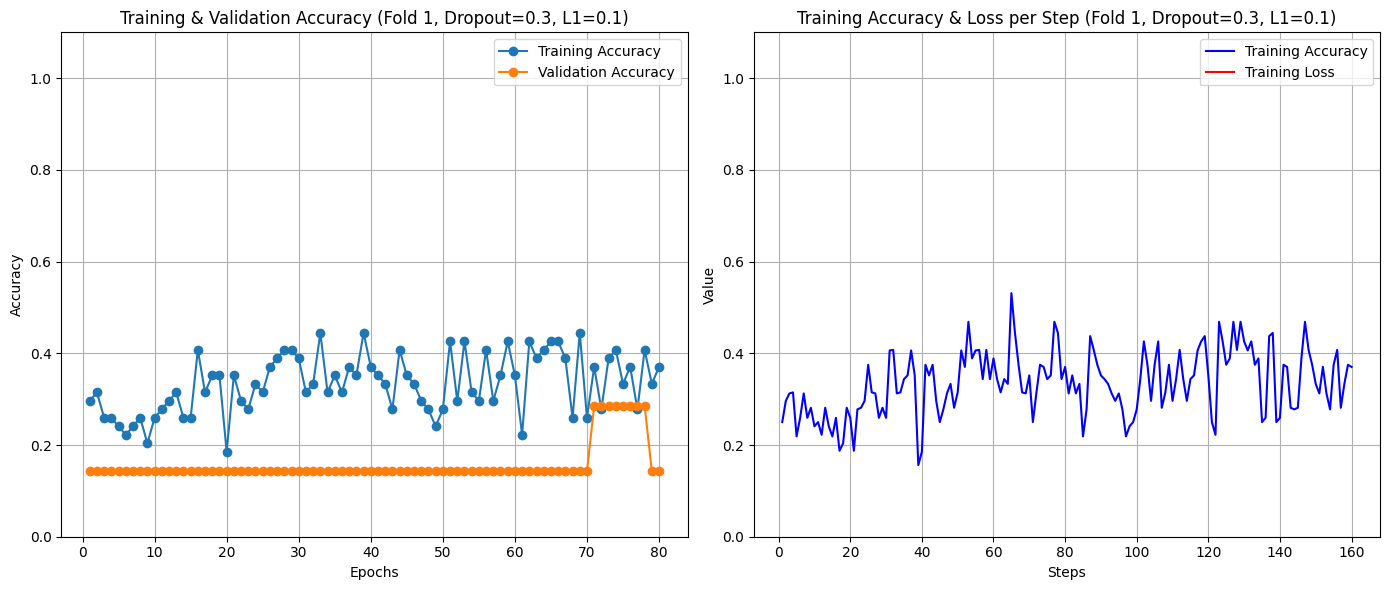

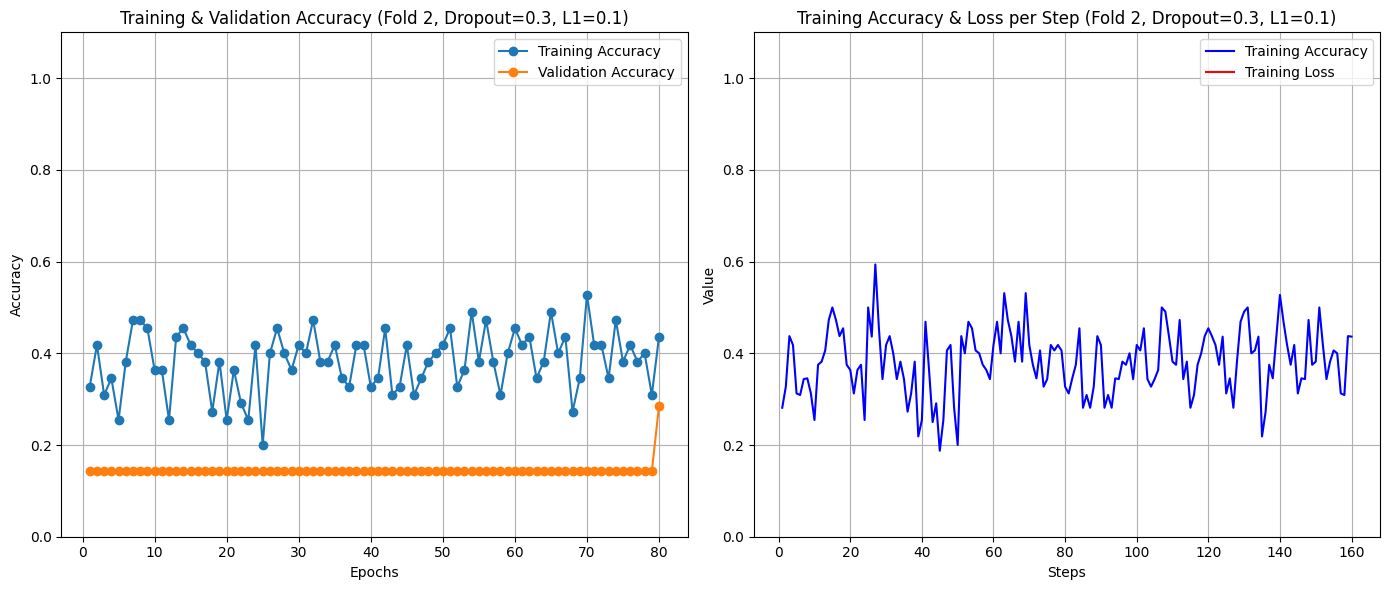

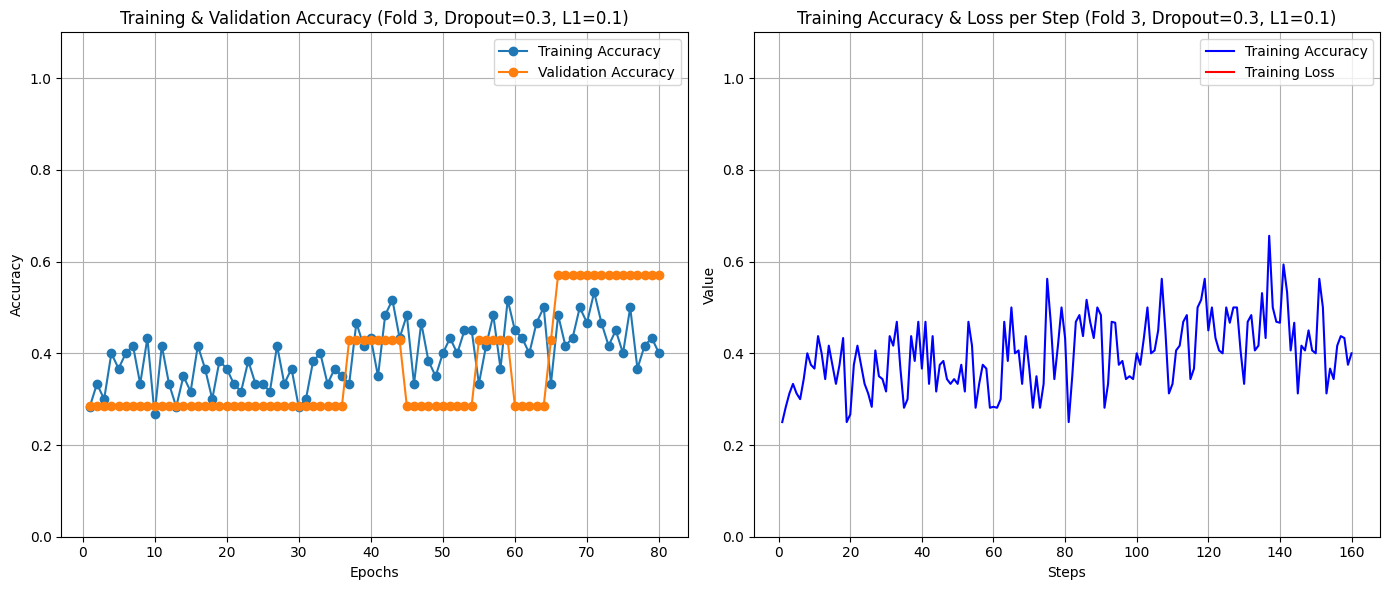

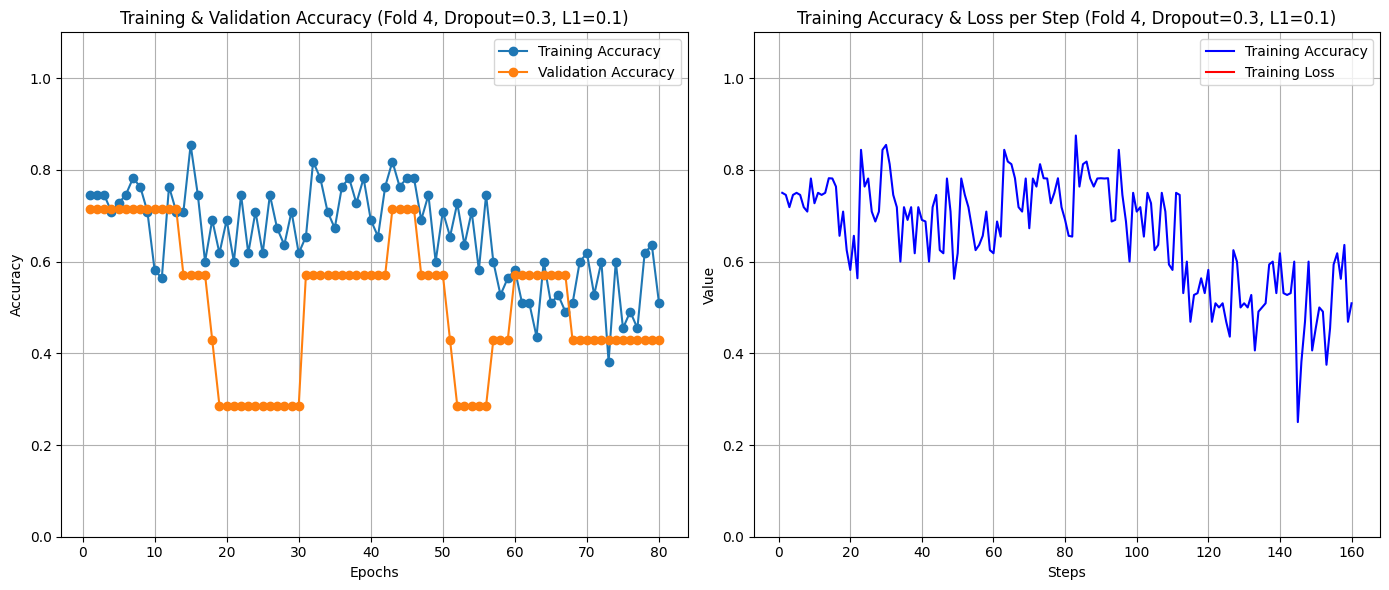

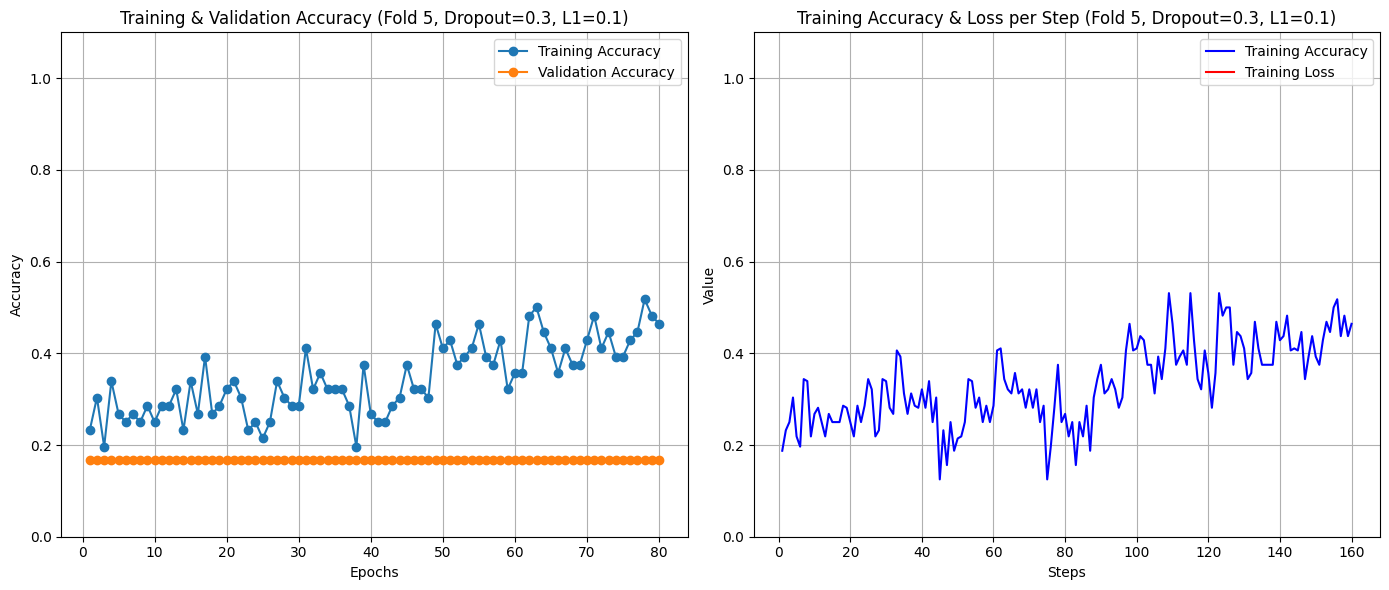

Plotting for combination 2 (Dropout=0.4, L1=0.1)


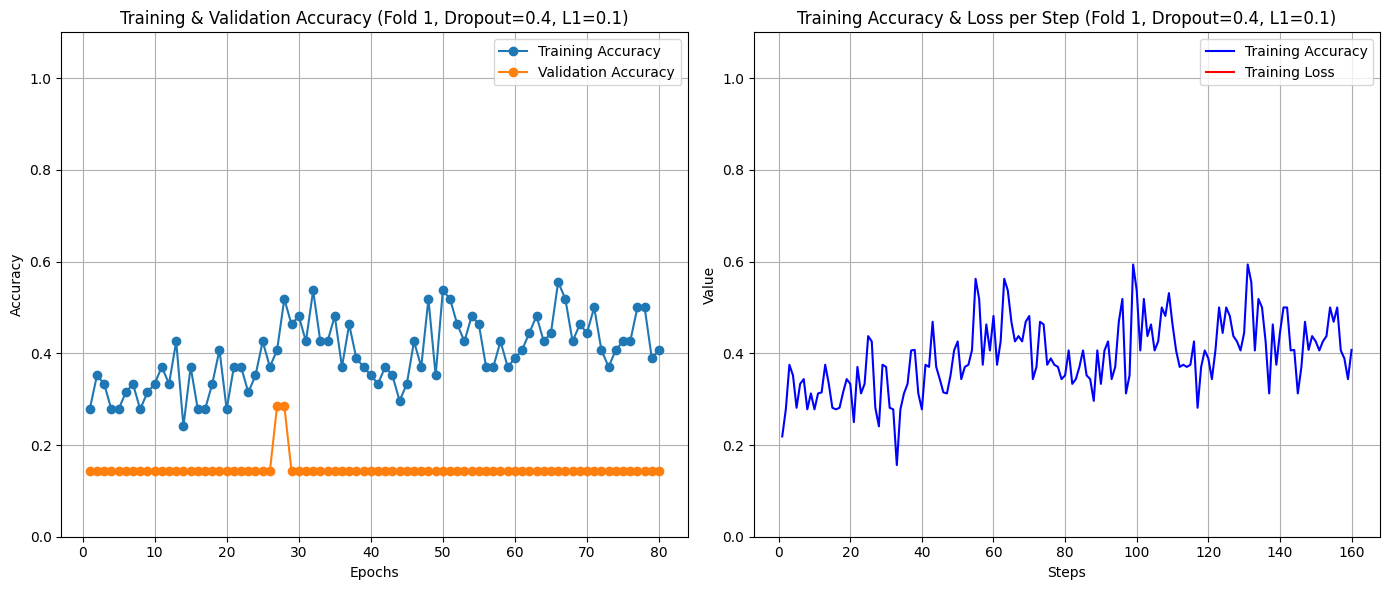

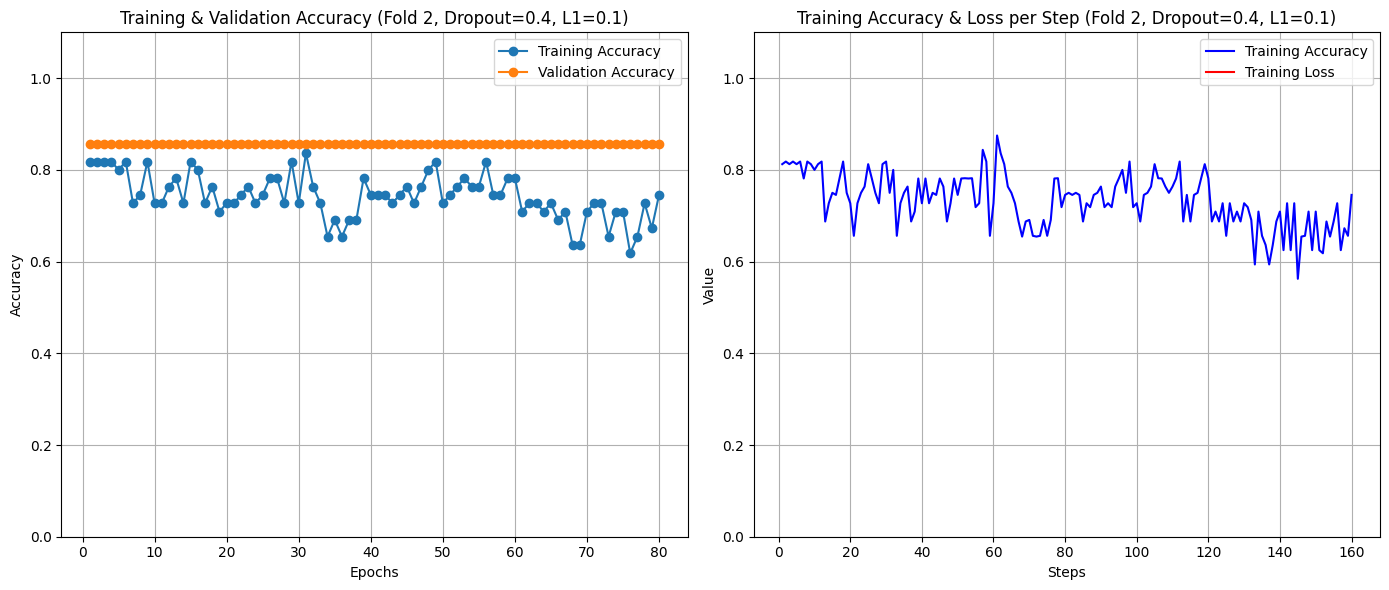

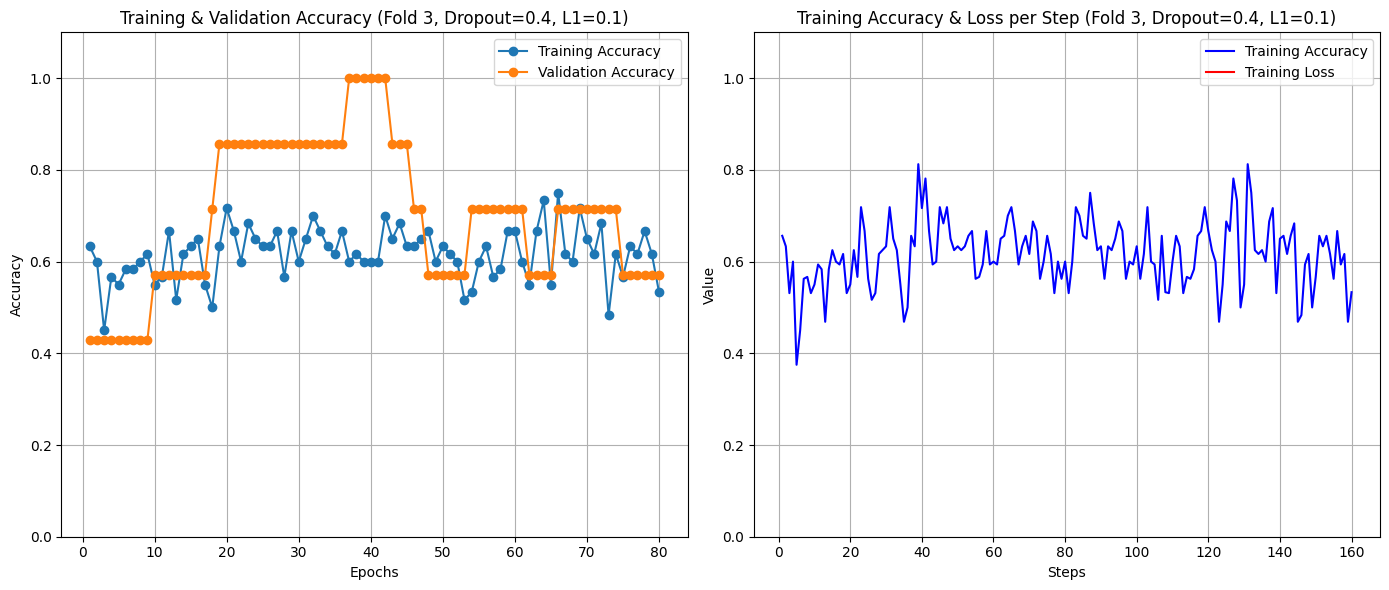

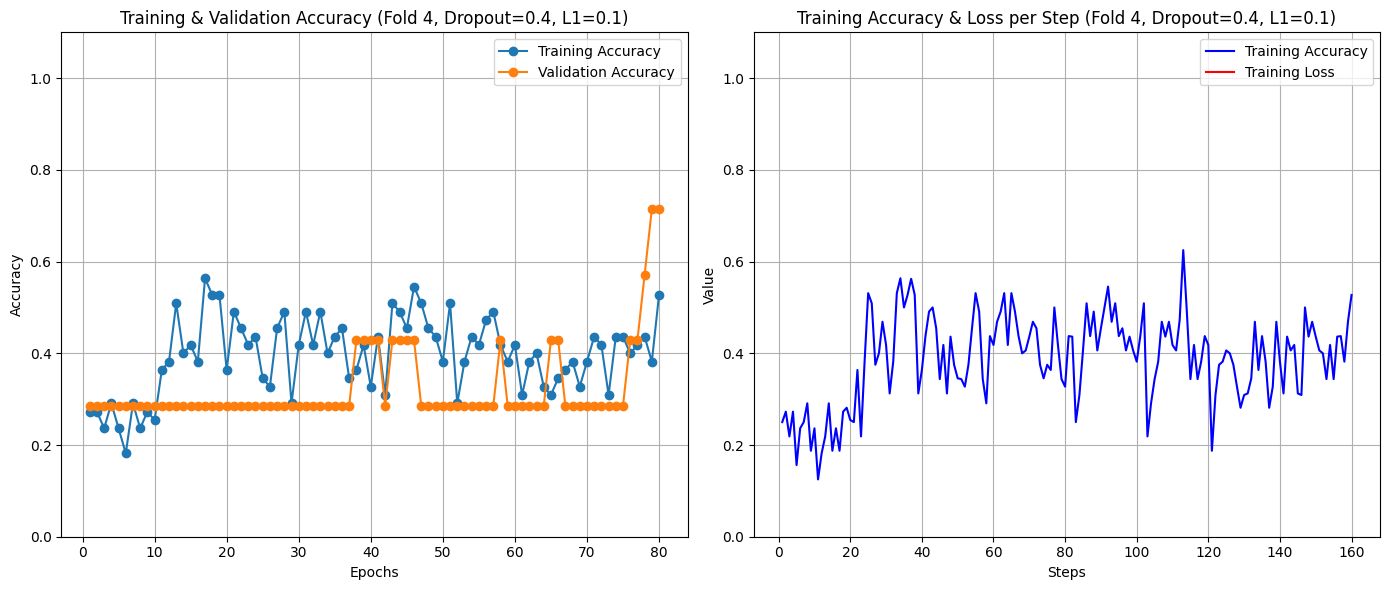

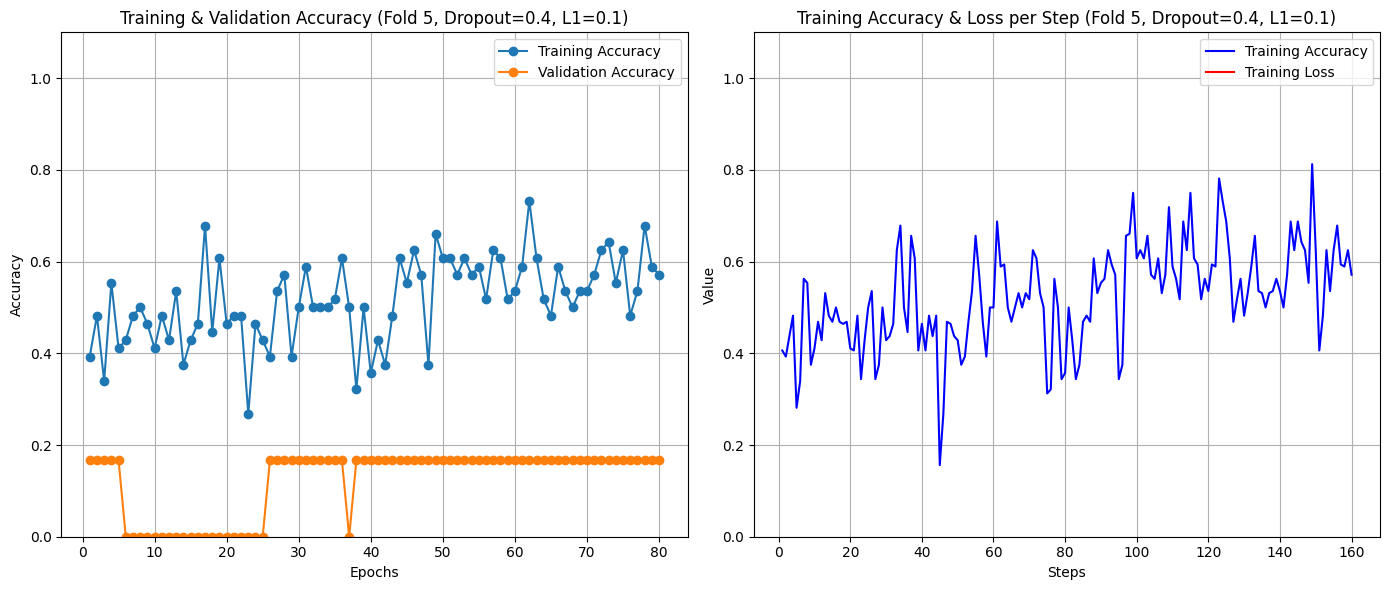

Plotting for combination 3 (Dropout=0.5, L1=0.1)


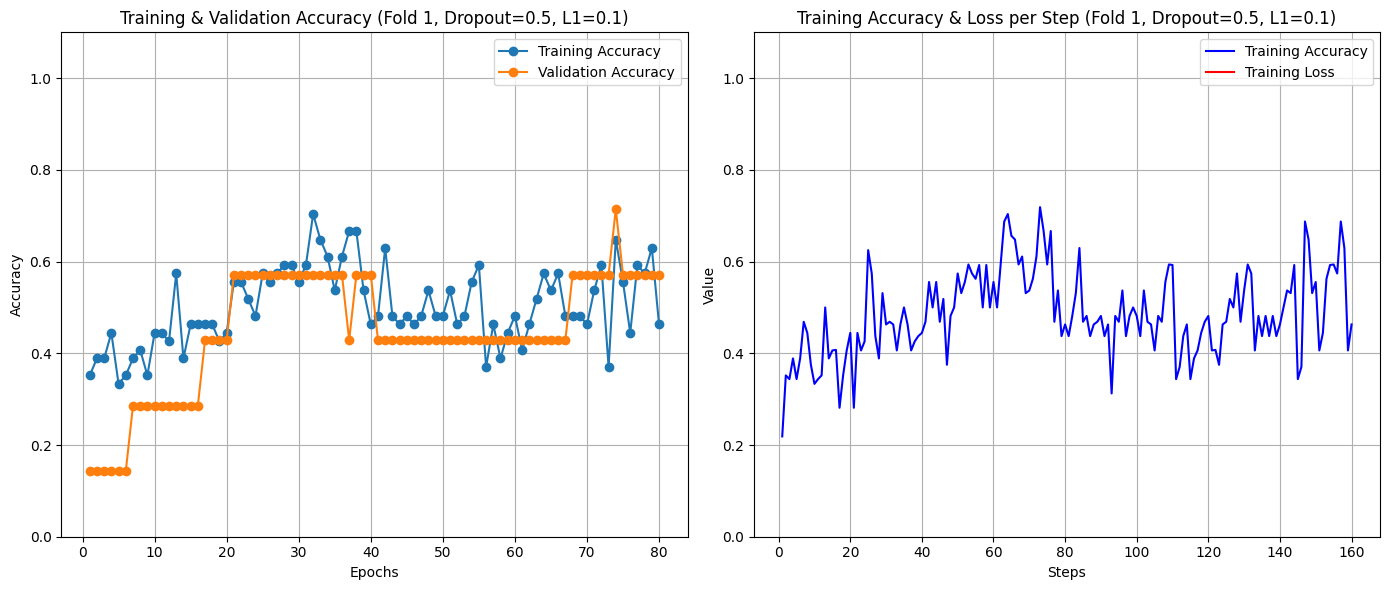

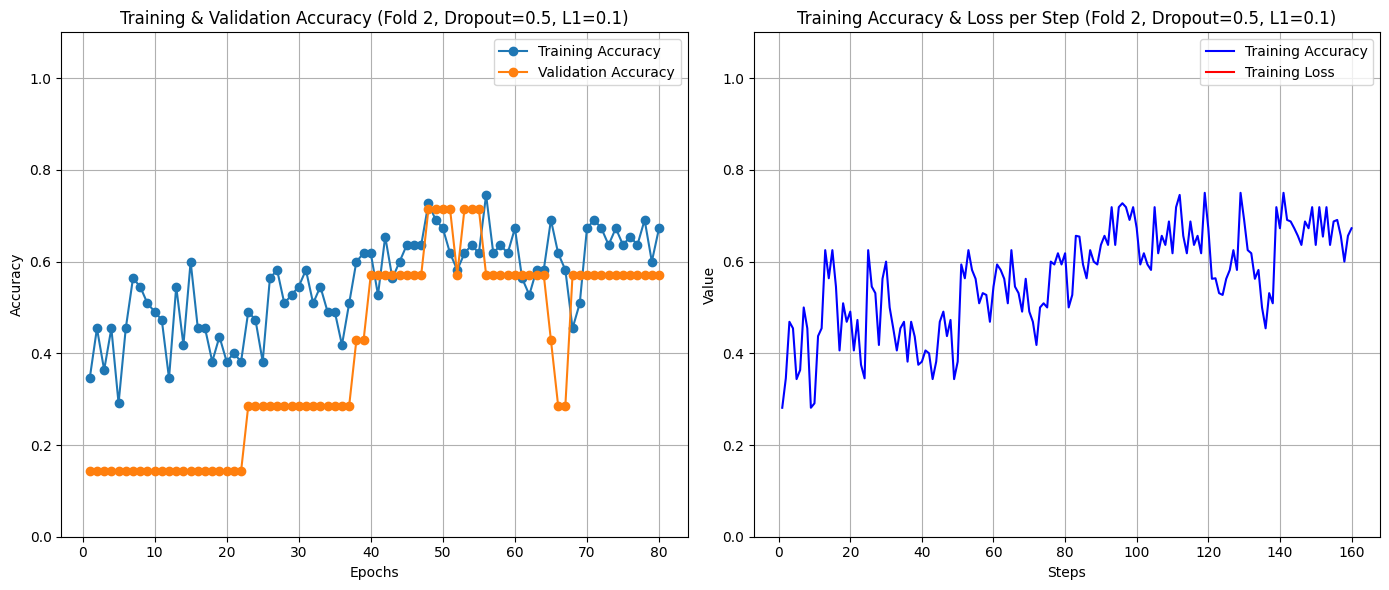

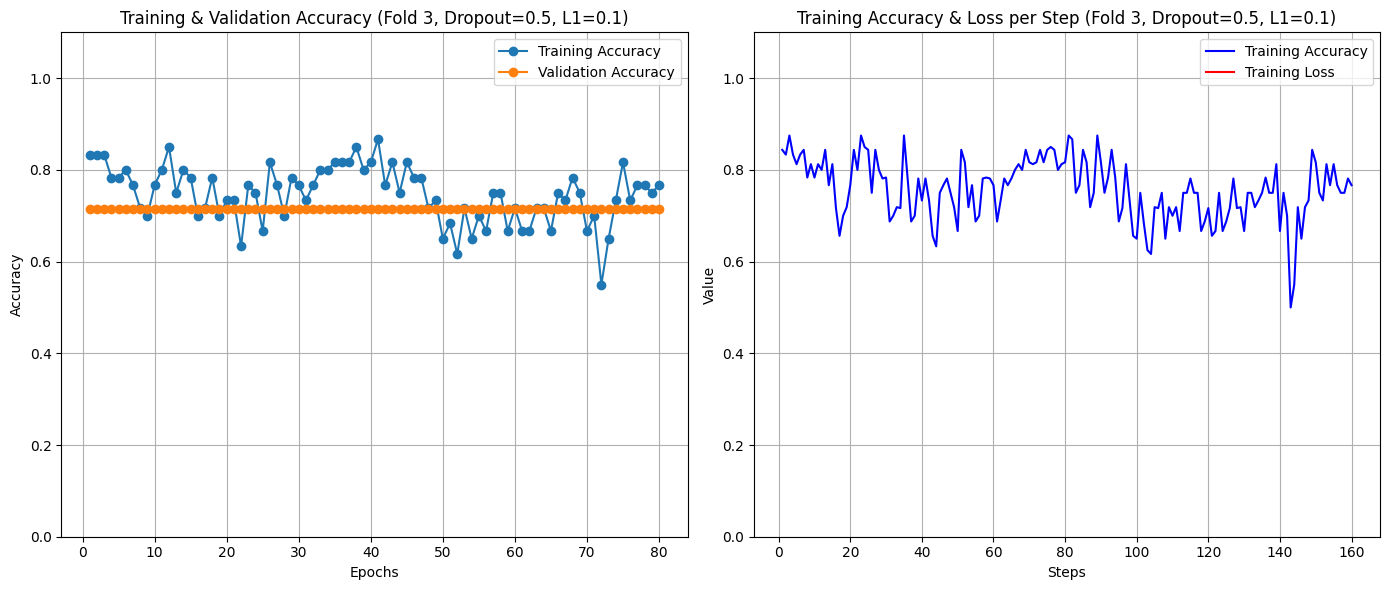

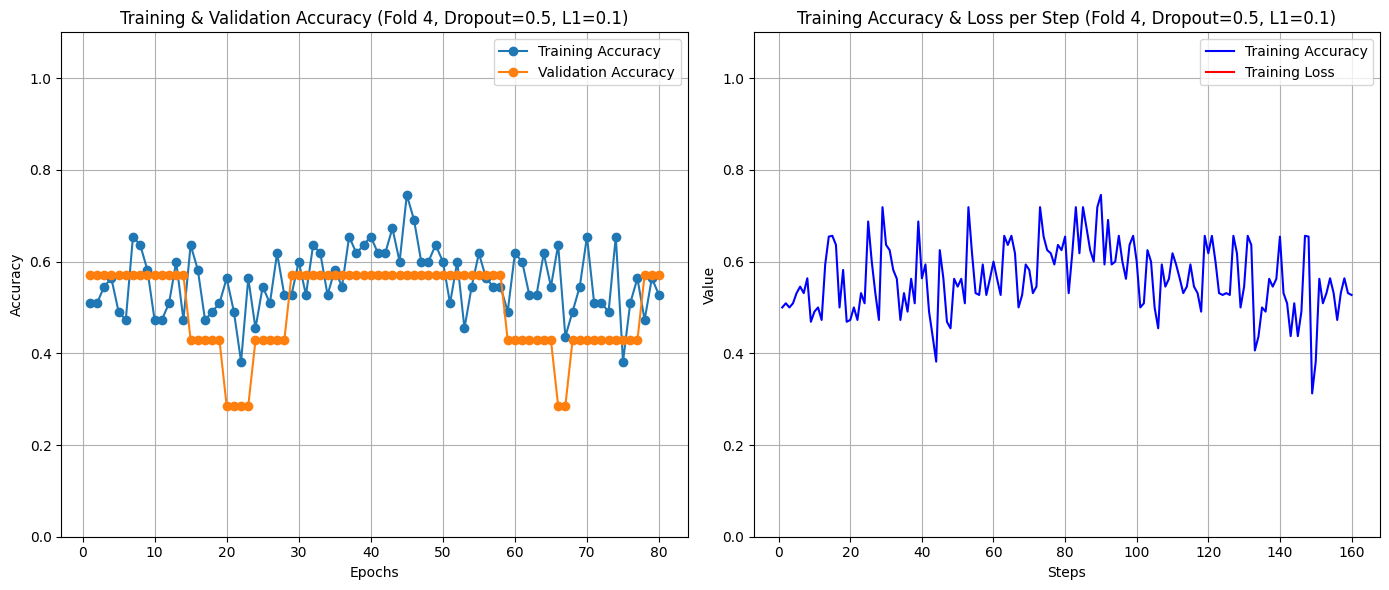

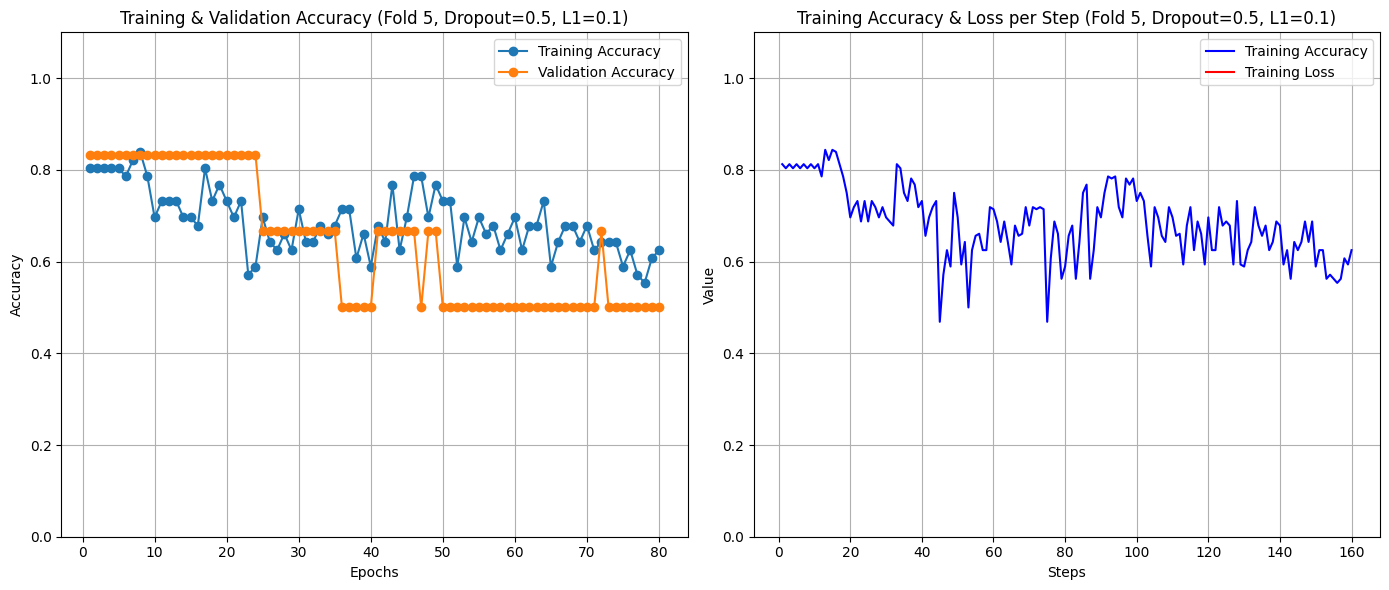

Plotting for combination 4 (Dropout=0.6, L1=0.1)


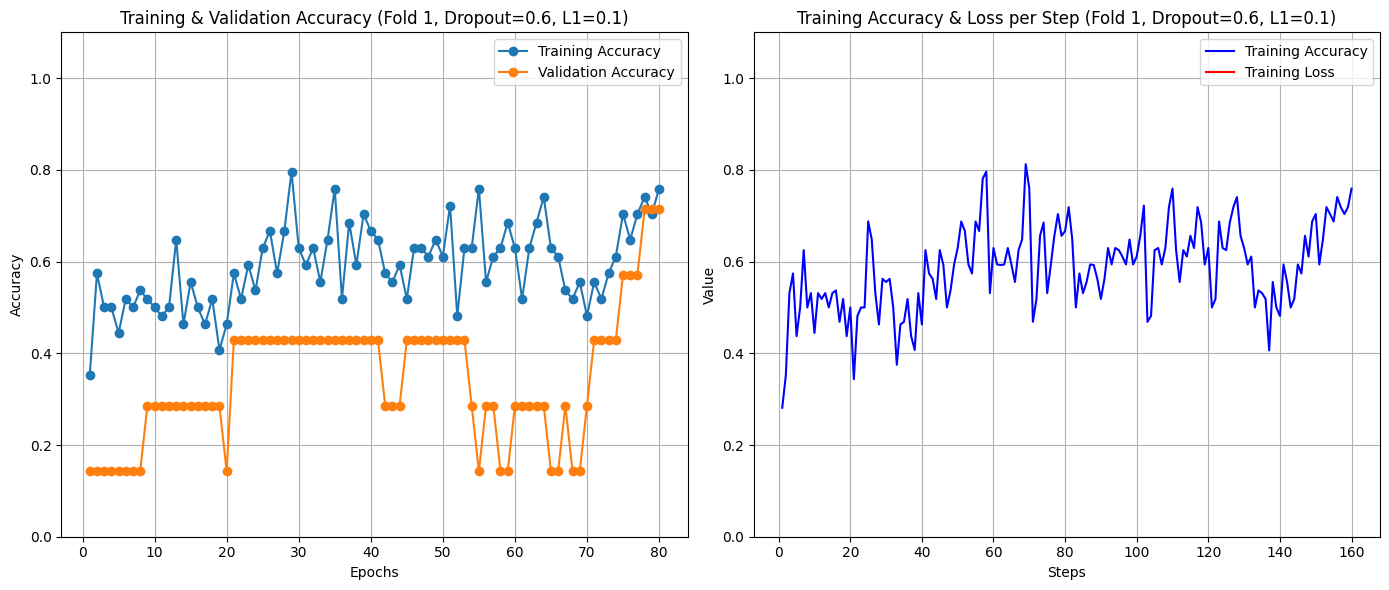

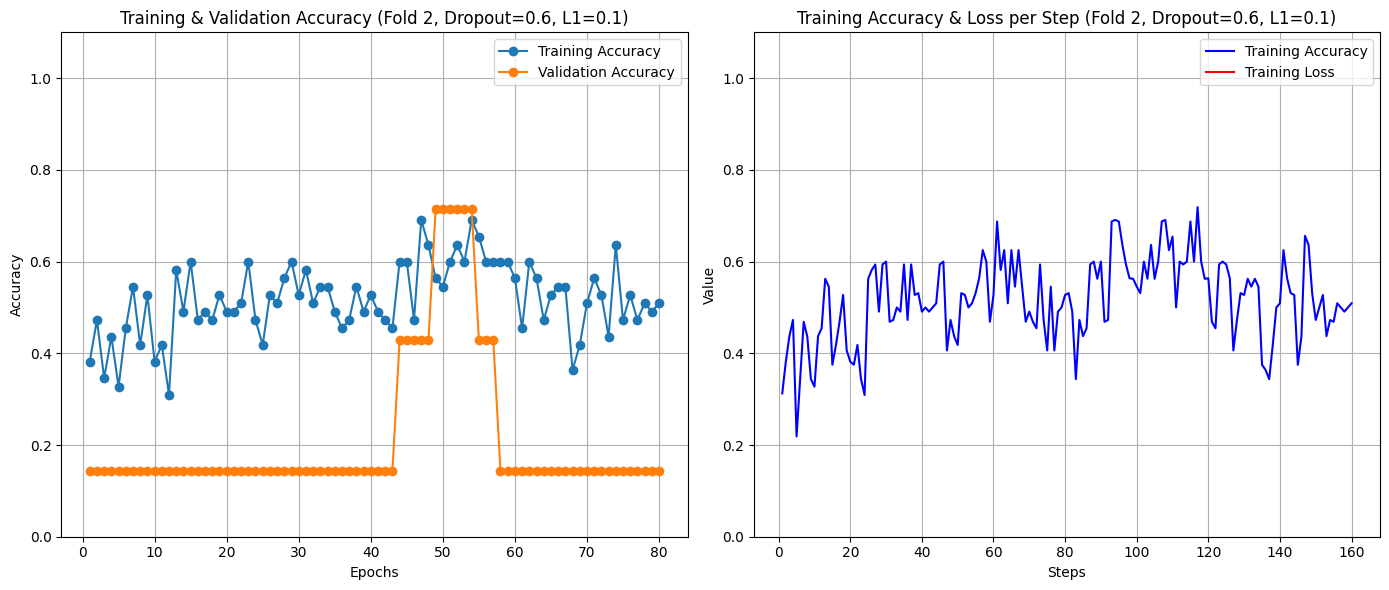

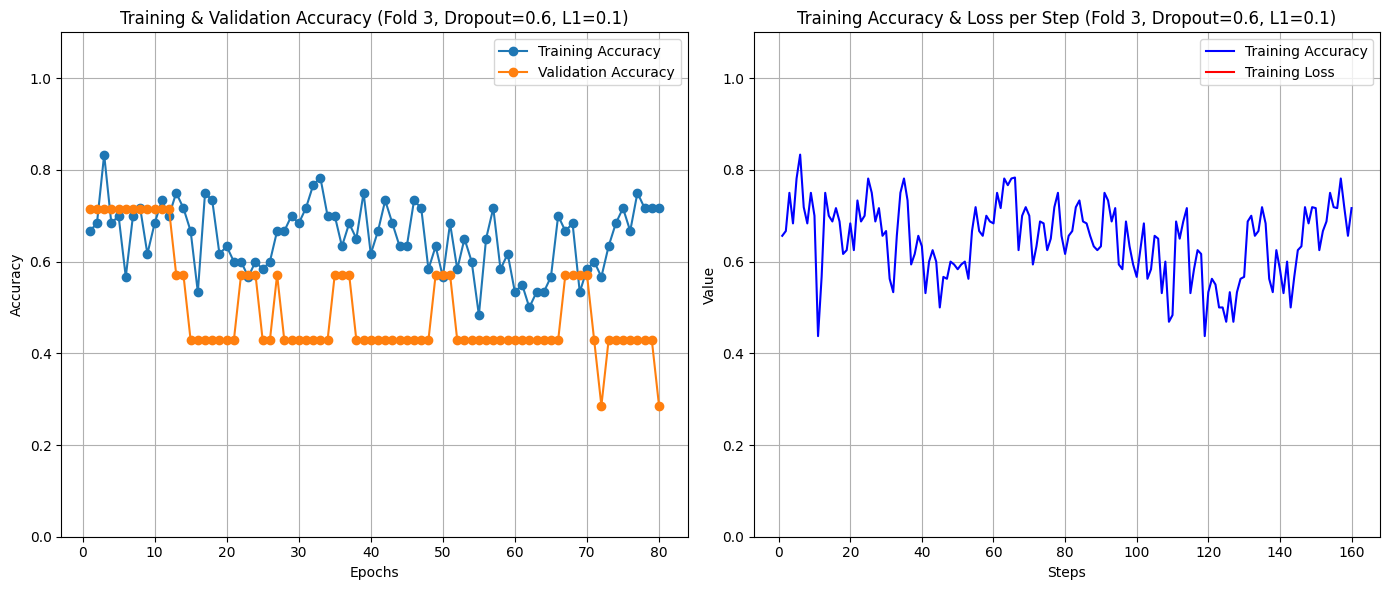

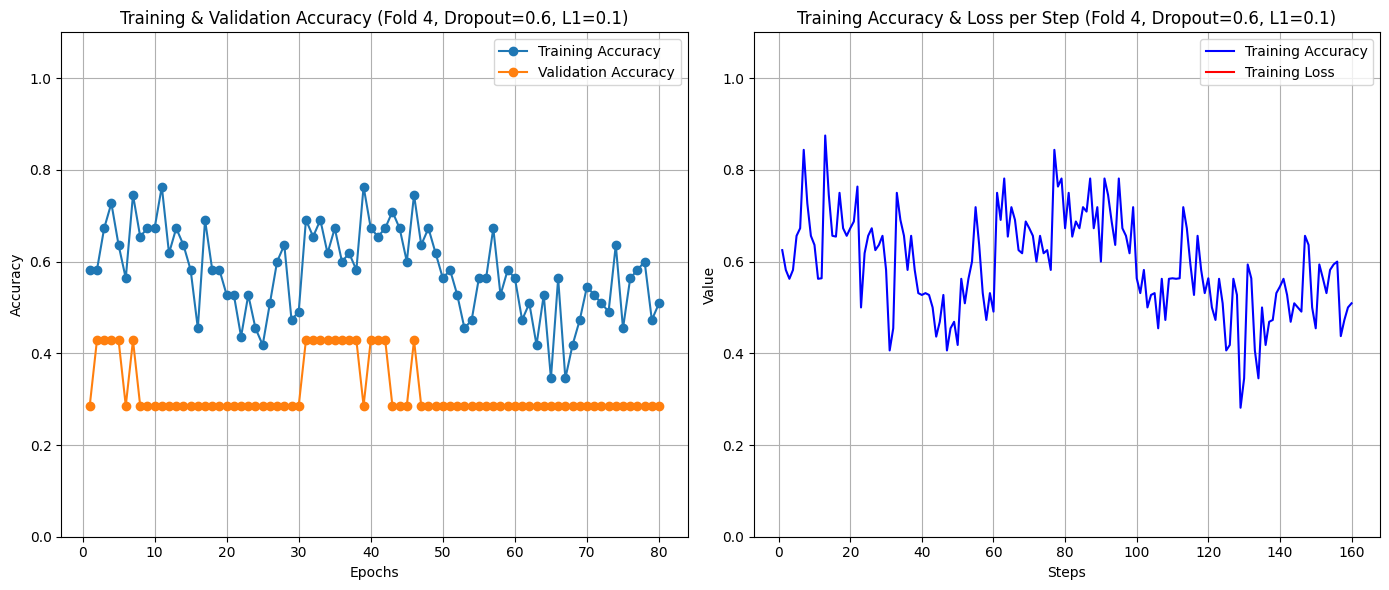

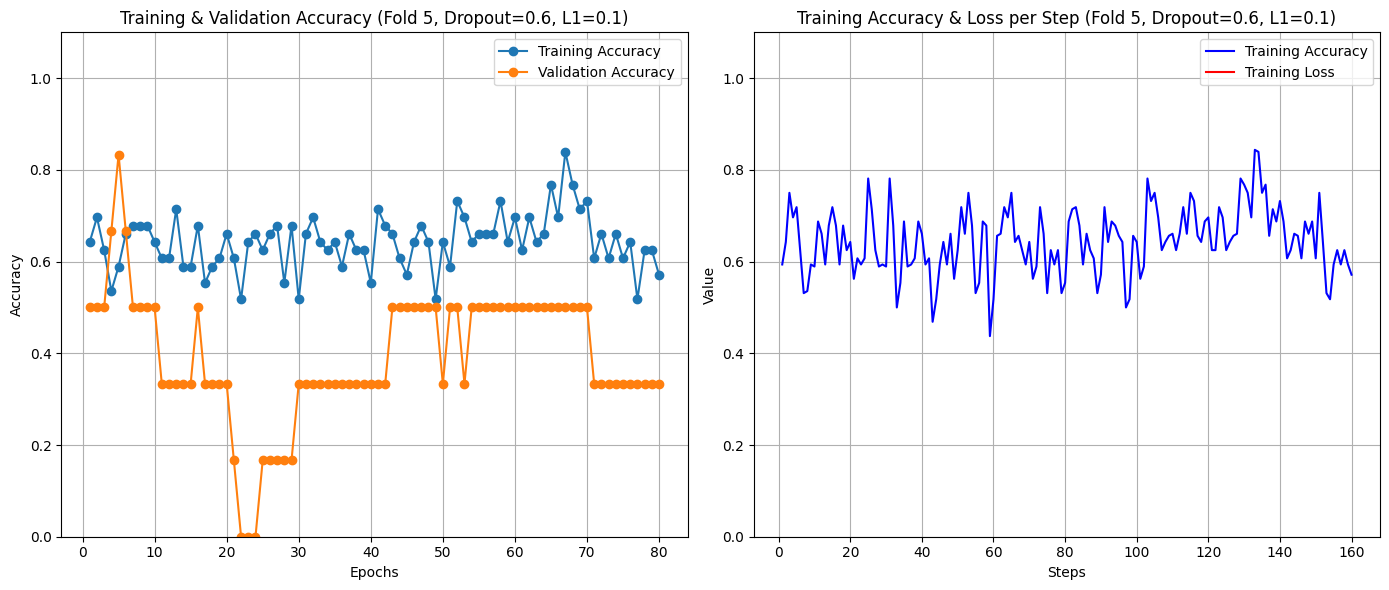

Plotting for combination 5 (Dropout=0.7, L1=0.1)


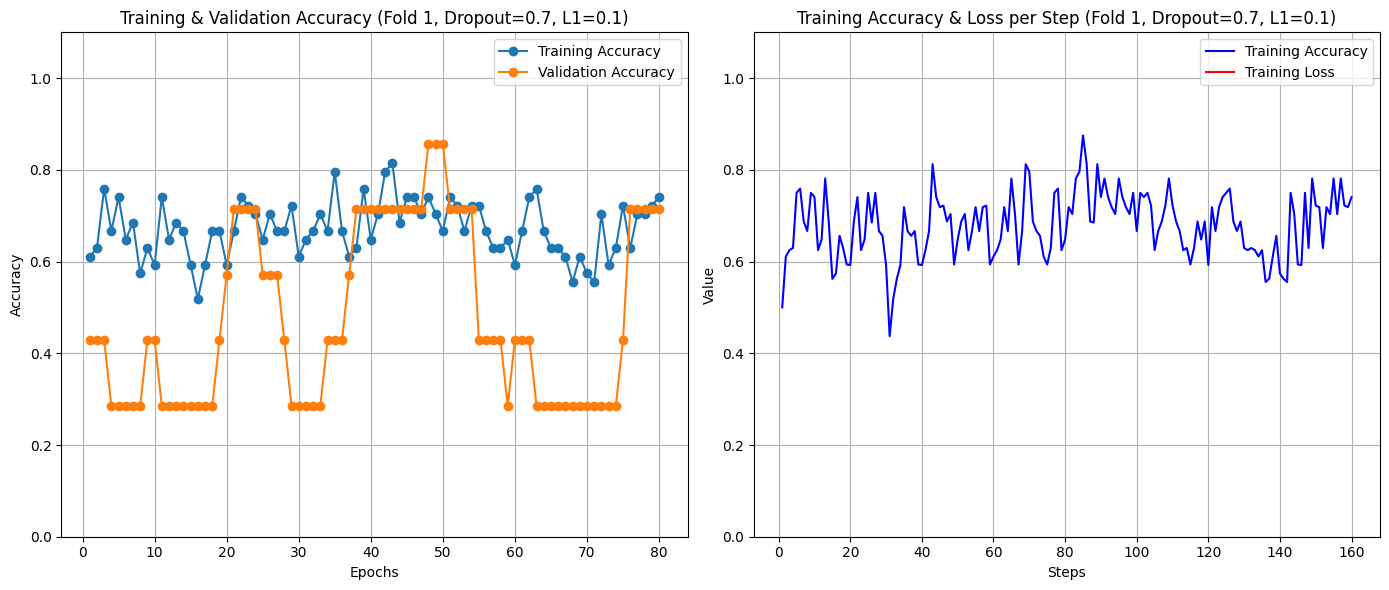

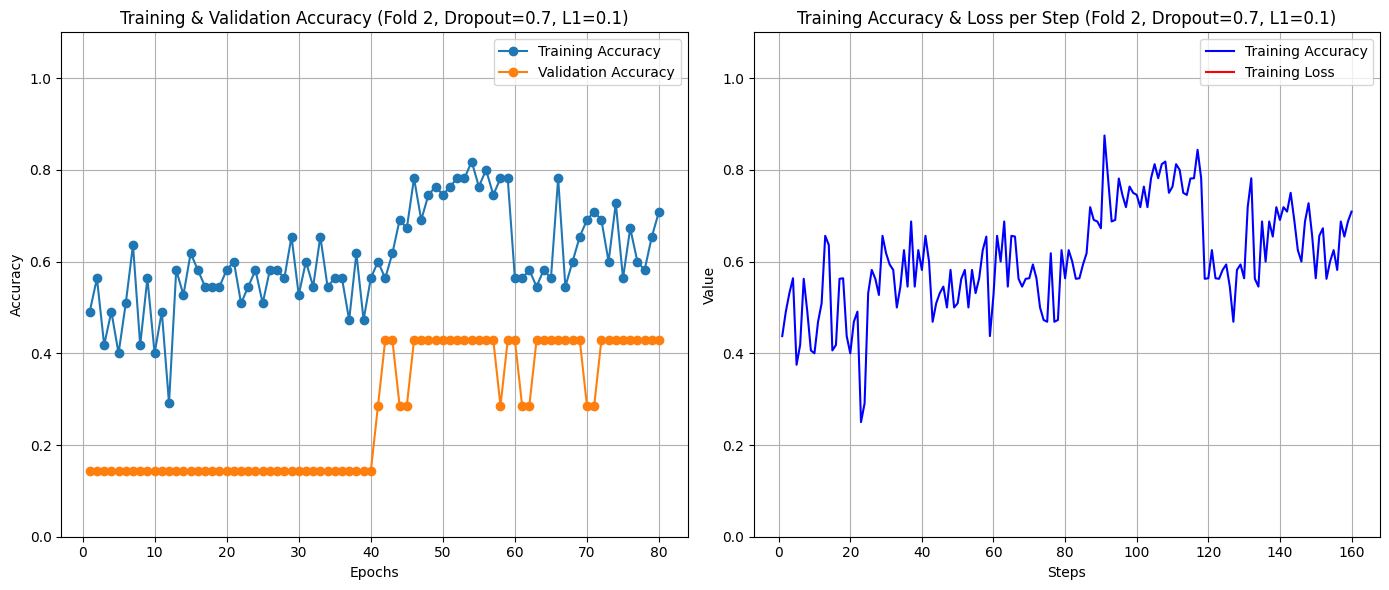

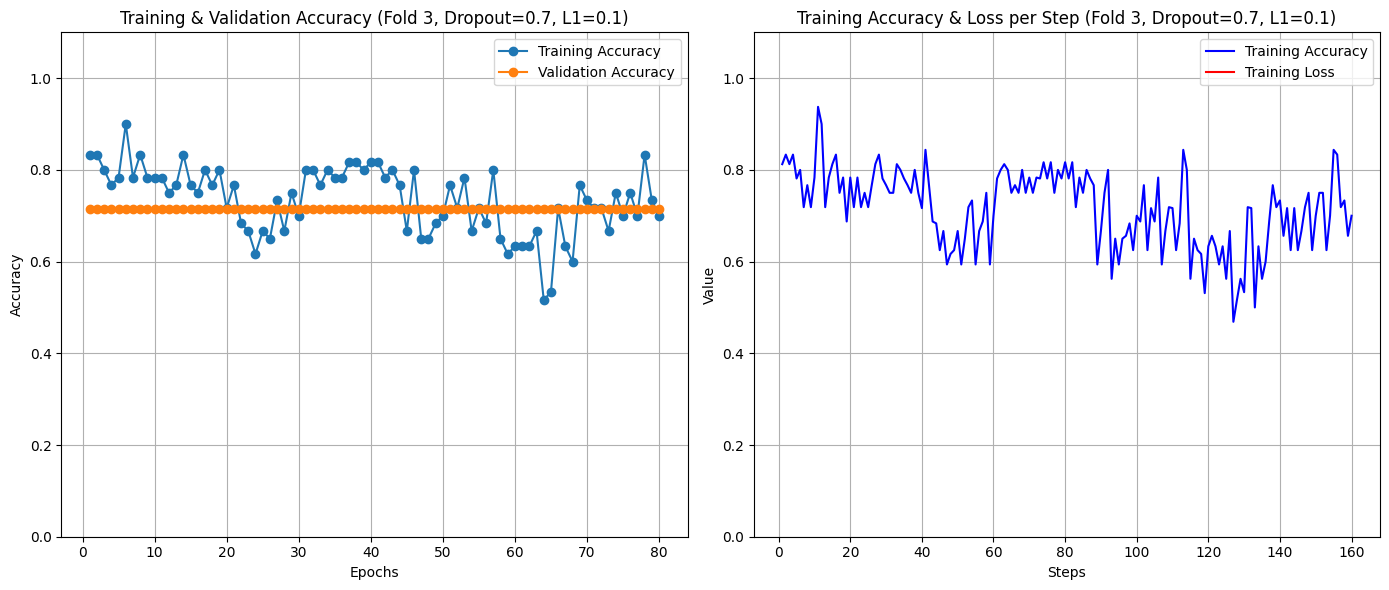

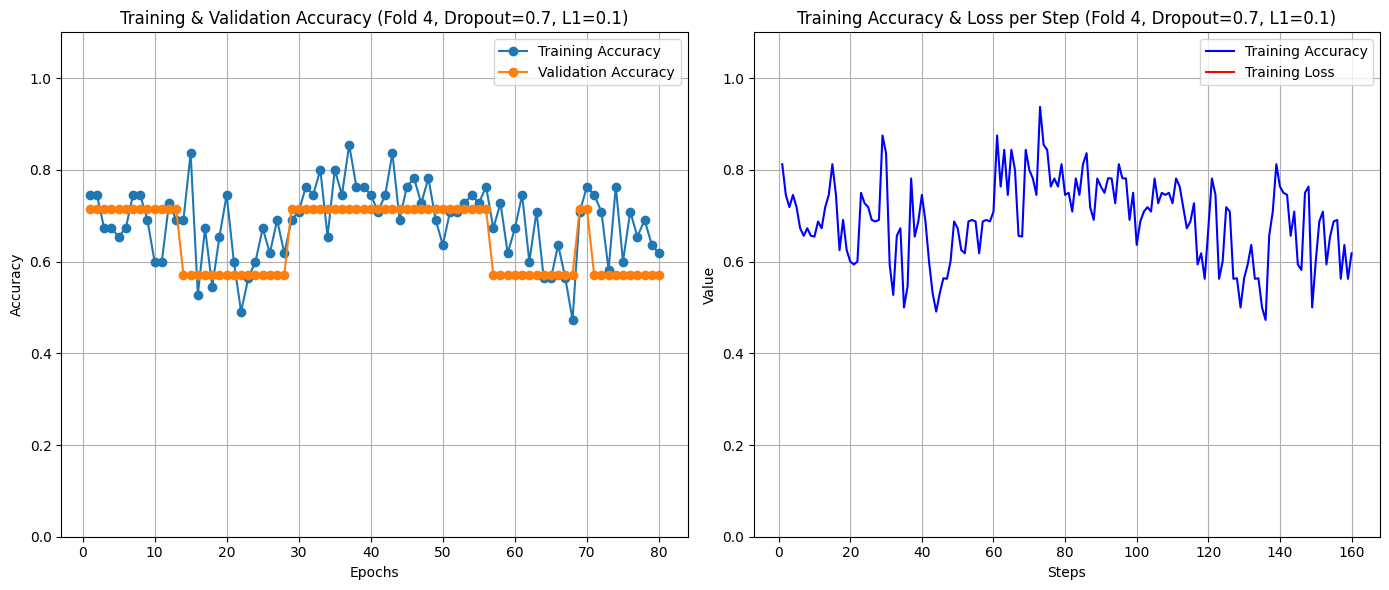

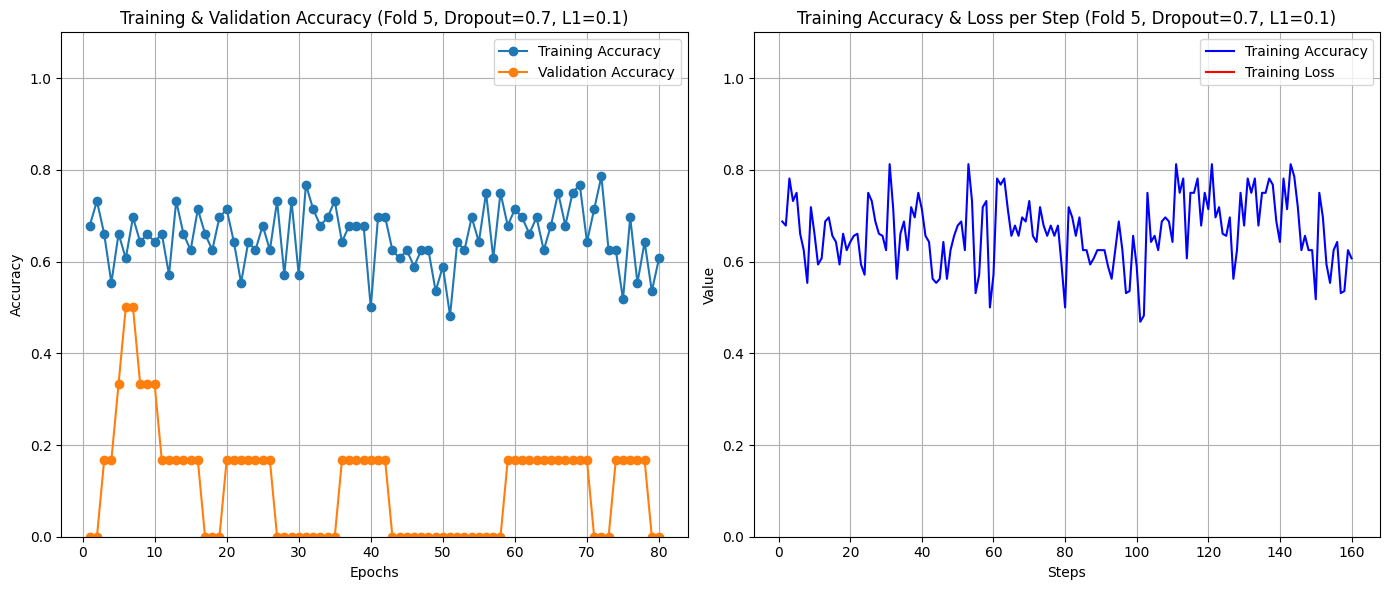

Plotting for combination 6 (Dropout=0.8, L1=0.1)


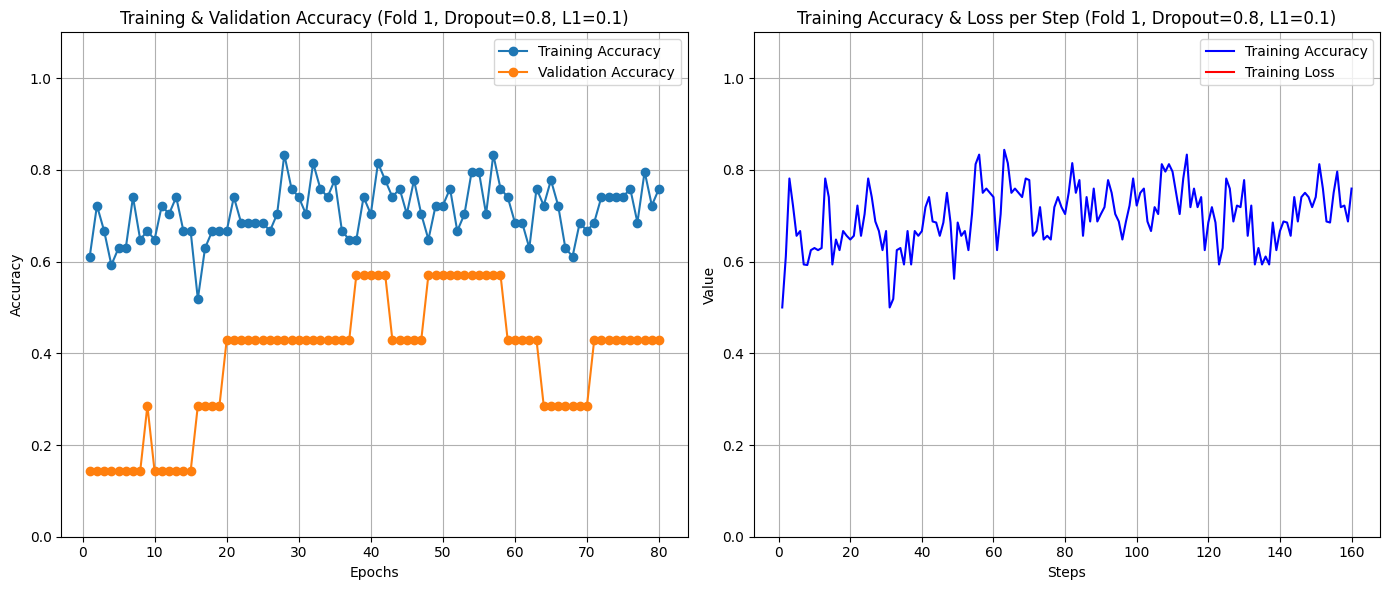

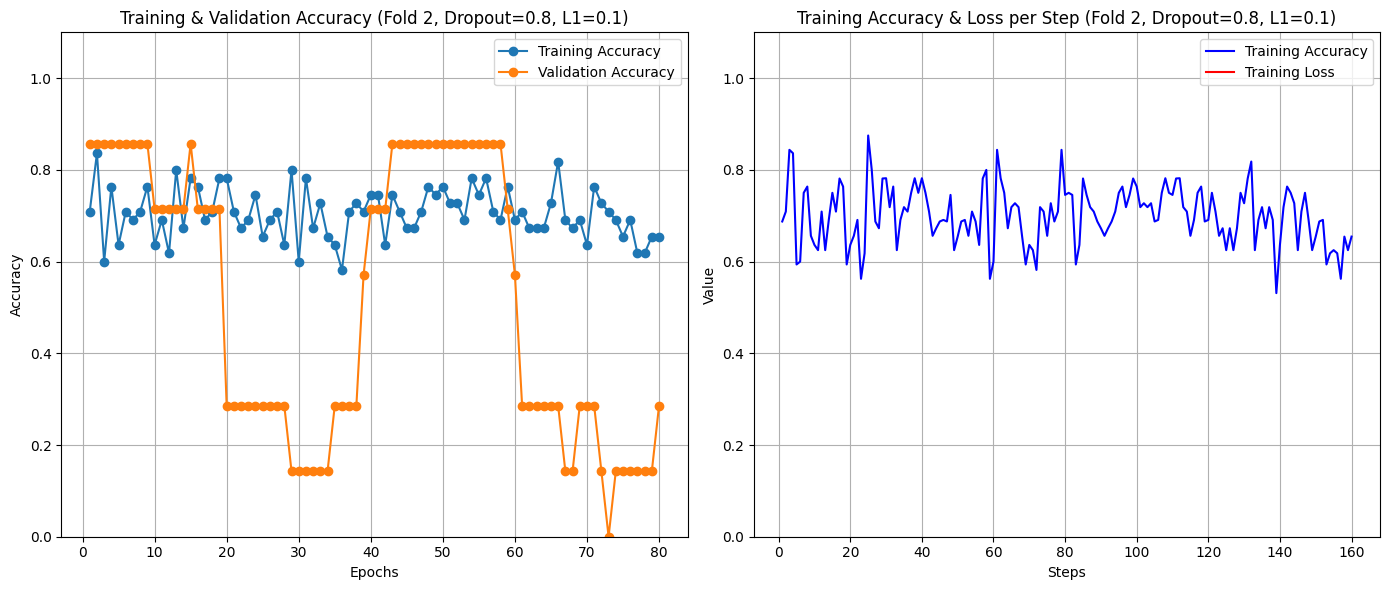

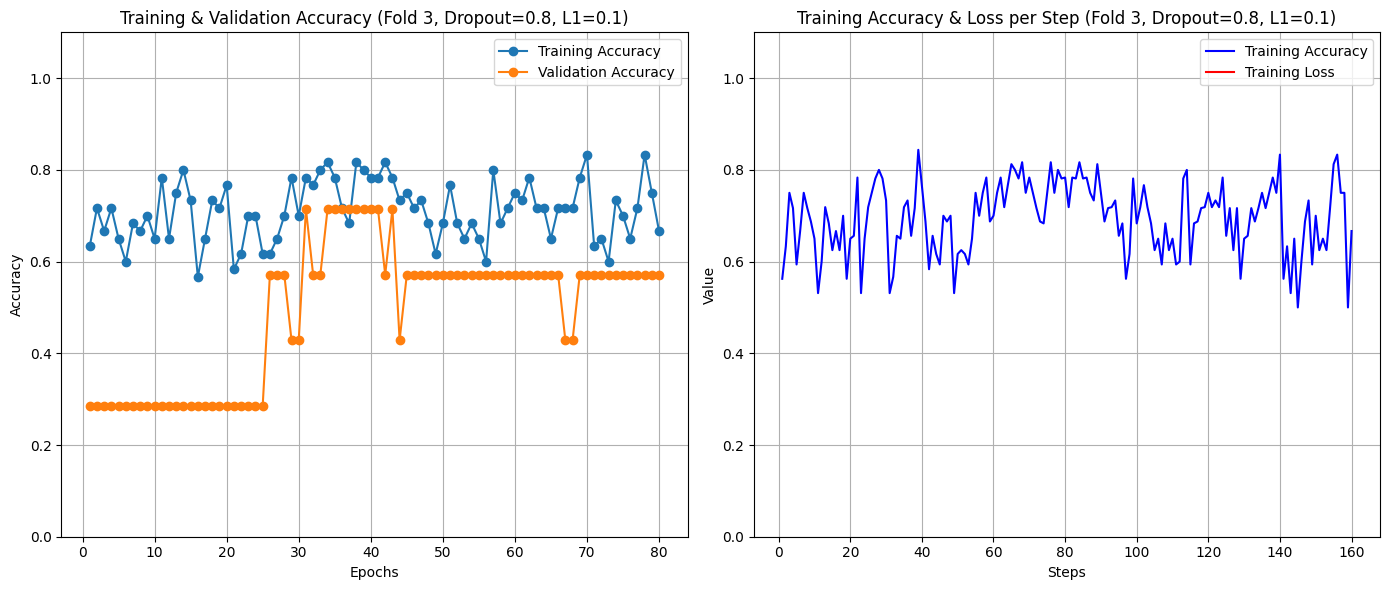

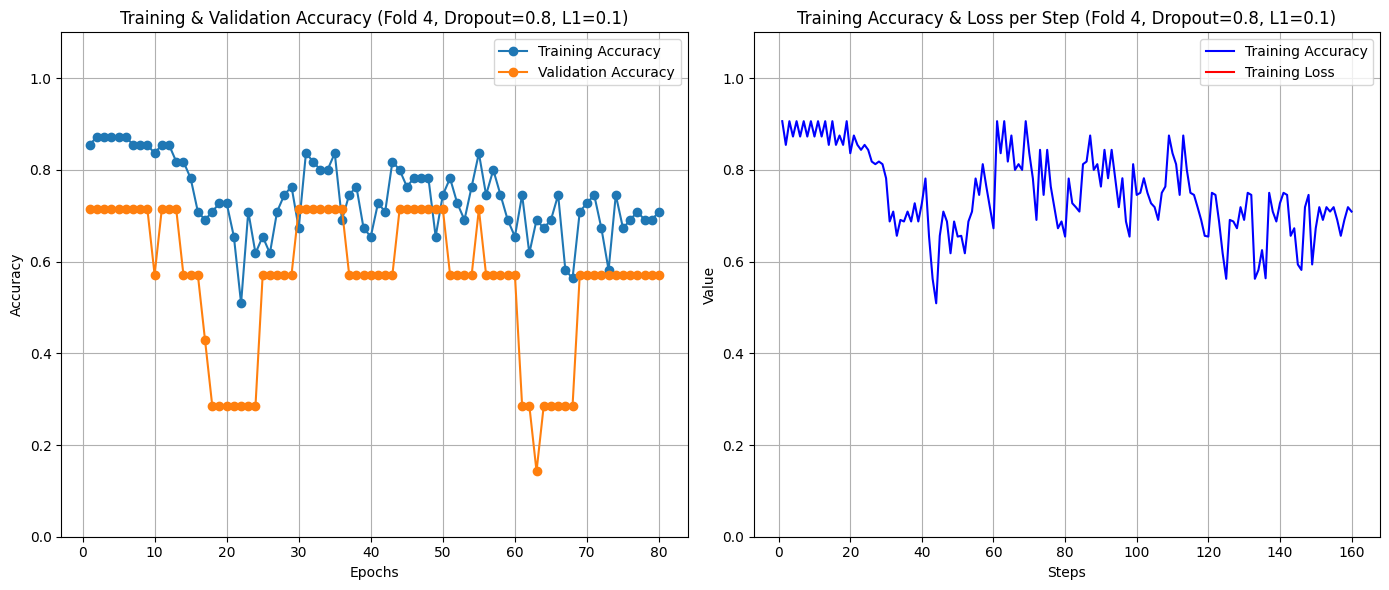

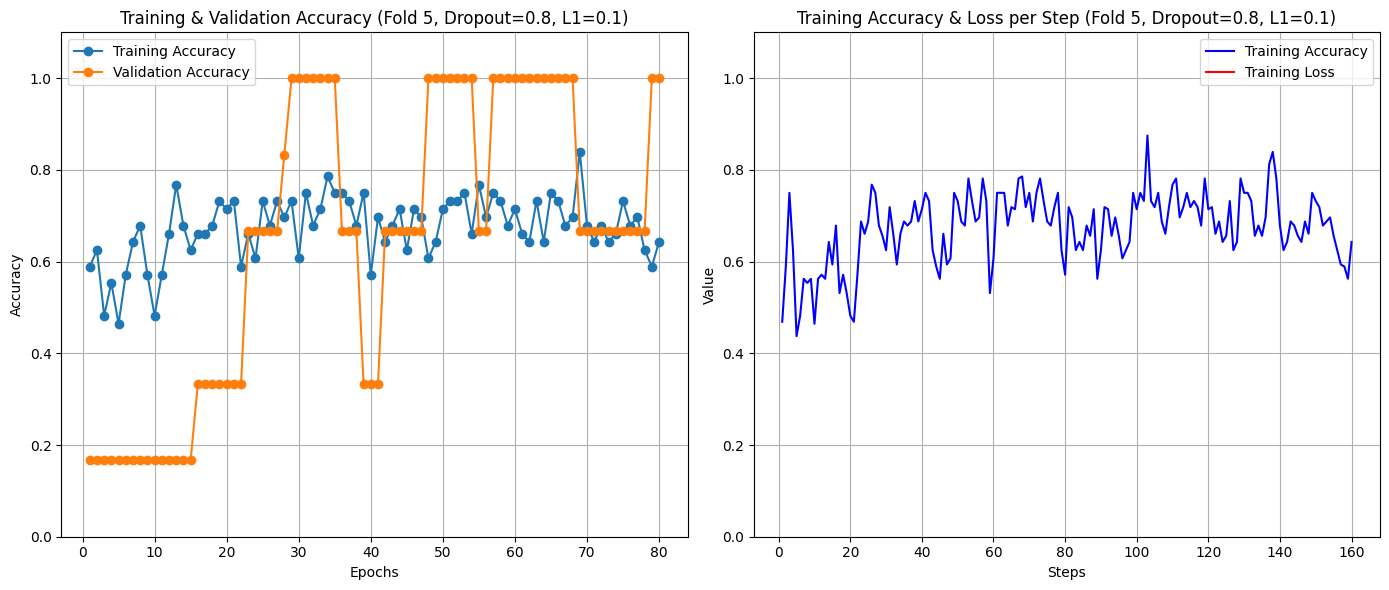

Plotting for combination 7 (Dropout=0.9, L1=0.1)


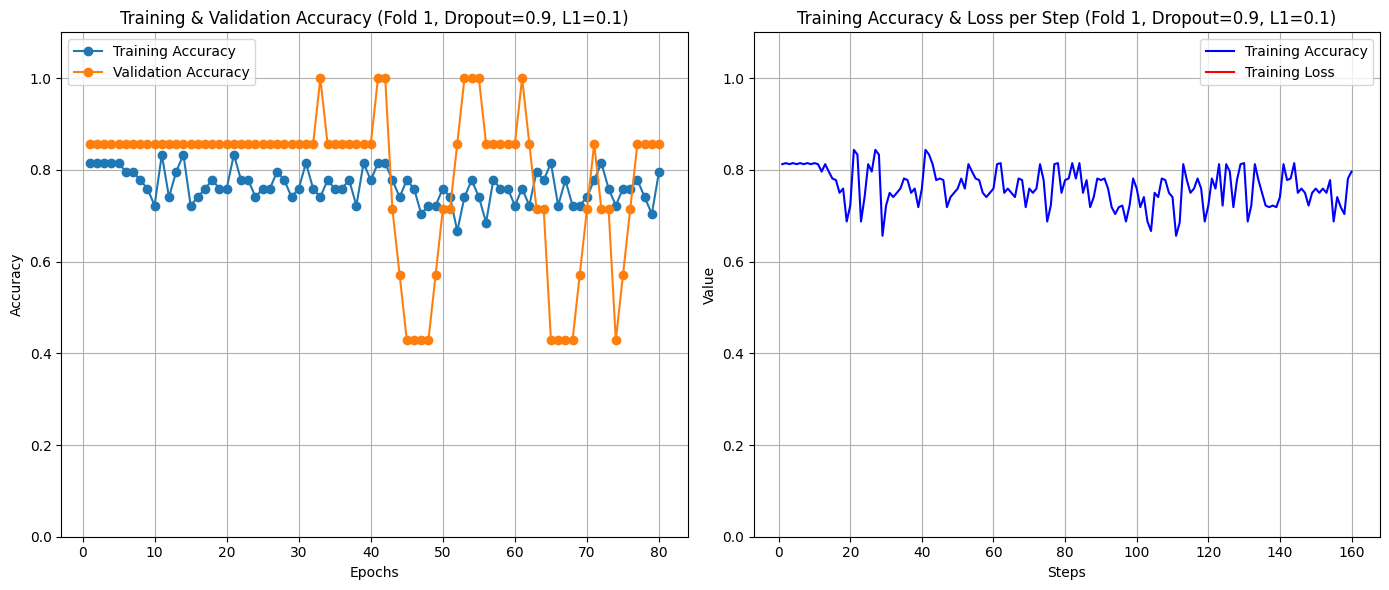

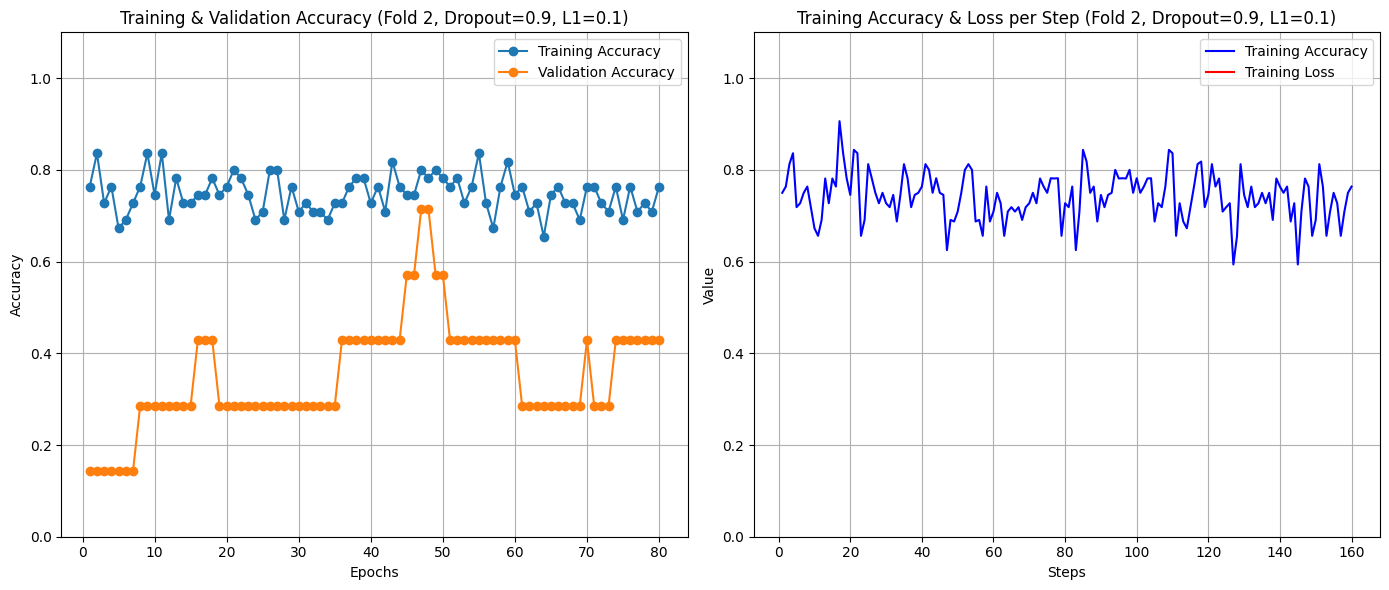

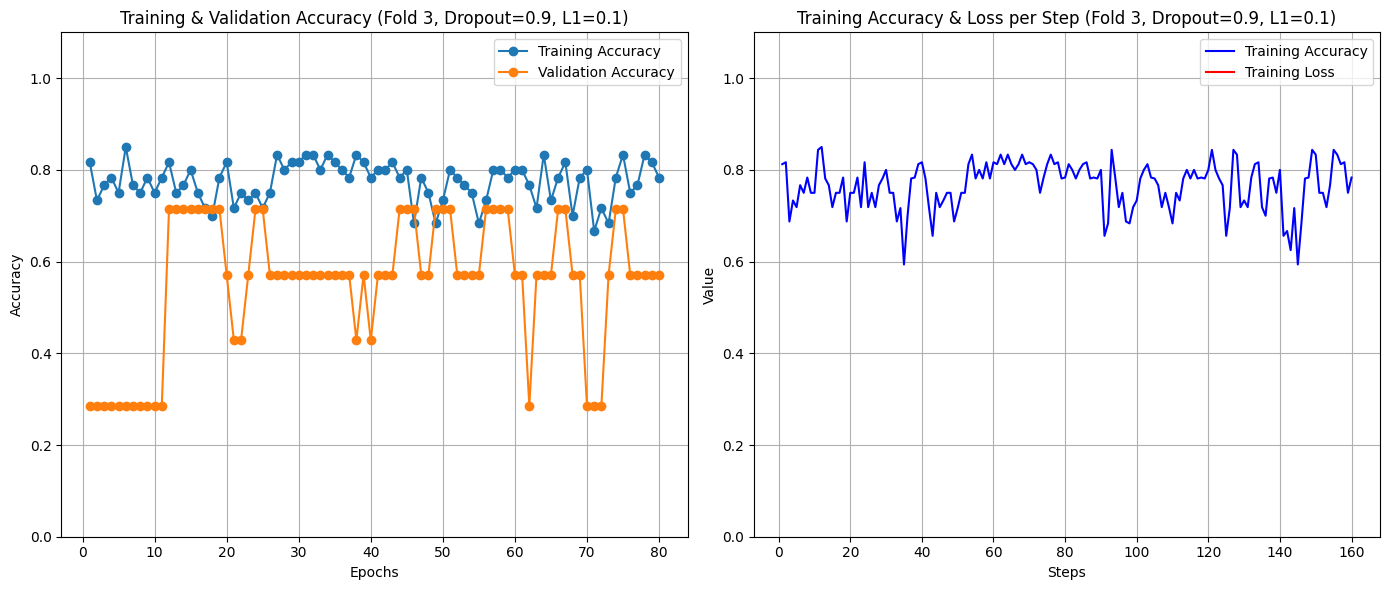

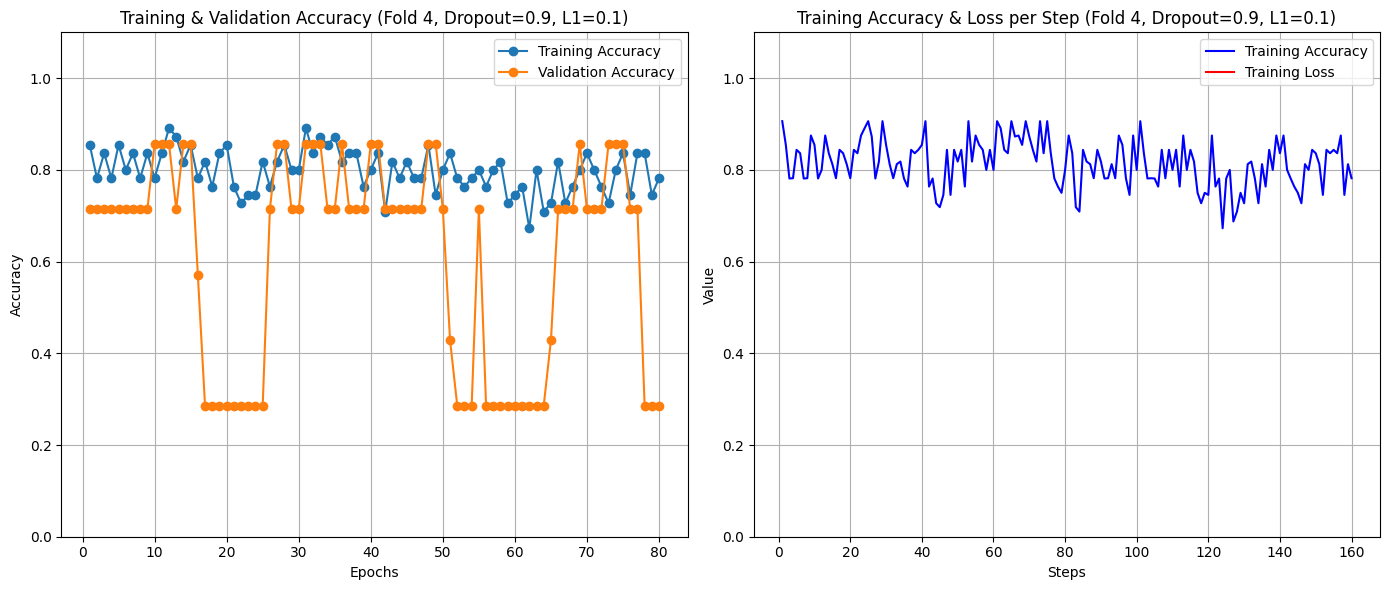

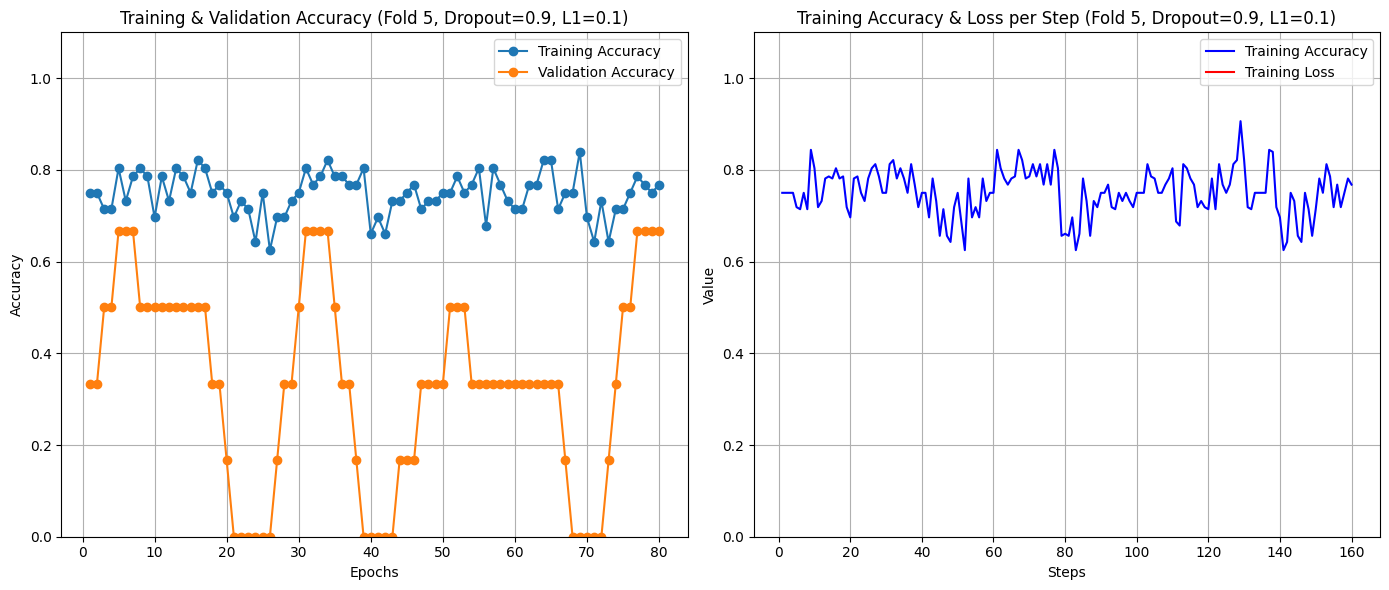

In [11]:
import os
import matplotlib.pyplot as plt


# Function to plot training metrics and include dropout and L1 values in the plot titles
def plot_training_metrics(history, custom_cp_callback, fold_number, drop_out_fully_connected, reg_l1):
    """
    Plot training and validation accuracy per epoch, as well as training accuracy and loss per step.

    Parameters:
    history (tf.keras.callbacks.History): History object returned from model.fit(), containing epoch-wise accuracy data.
    custom_cp_callback (CustomModelCheckpoint): Custom callback instance that captures step-wise accuracy and loss data.
    fold_number (int): The fold number for labeling the plots.
    drop_out_fully_connected (float): Dropout value for fully connected layers.
    reg_l1 (float): L1 regularization value.
    """
    # Extract accuracy and validation accuracy from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    # Plot the training and validation accuracy per epoch
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title(f'Training & Validation Accuracy (Fold {fold_number}, Dropout={drop_out_fully_connected}, L1={reg_l1})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.1)  # Set the same y-axis limits for accuracy
    plt.legend()
    plt.grid(True)

    # Plot the accuracies and losses per step
    steps = range(1, len(custom_cp_callback.step_accuracies) + 1)
    plt.subplot(1, 2, 2)
    plt.plot(steps, custom_cp_callback.step_accuracies, 'b-', label='Training Accuracy')
    plt.plot(steps, custom_cp_callback.step_losses, 'r-', label='Training Loss')
    plt.title(f'Training Accuracy & Loss per Step (Fold {fold_number}, Dropout={drop_out_fully_connected}, L1={reg_l1})')
    plt.xlabel('Steps')
    plt.ylabel('Value')
    plt.ylim(0, 1.1)  # Set the same y-axis limits for accuracy
    plt.legend()
    plt.grid(True)

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

# Plotting the training metrics for all combinations
for idx, (fold_histories, custom_callbacks) in enumerate(zip(all_fold_histories, all_custom_callbacks)):
    # Get the corresponding dropout and L1 values for this combination
    drop_out_fully_connected = dropout_values[idx // len(l1_values)]
    reg_l1 = l1_values[idx % len(l1_values)]
    
    print(f"Plotting for combination {idx + 1} (Dropout={drop_out_fully_connected}, L1={reg_l1})")

    # Loop through each fold for the current combination
    for fold_number, (history, custom_cp_callback) in enumerate(zip(fold_histories, custom_callbacks), start=1):
        plot_training_metrics(history, custom_cp_callback, fold_number, drop_out_fully_connected, reg_l1)